#**1.Importar as Bibliotecas**

In [ ]:
!pip install basemap basemap-data
!pip install xgboost

In [ ]:
# Manipulação de Dados
import pandas as pd
import numpy as np
import random

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap

# Aprendizado de Máquina
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBRegressor, XGBClassifier

# Métricas
from sklearn.metrics import (
    accuracy_score, mean_squared_error, r2_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

# Outros
from tabulate import tabulate
from google.colab import drive, files
import time


#**2.Carregar, Explorar  e tratar Dados do Dataset original**
- **Objetivo**: Verificar a estrutura do dataset, identificar valores ausentes e duplicados, e ter uma visão geral das primeiras linhas. E observar como os animais se movem em termos de longitude e latitude.

## 2.1 <u>Carregar o Dataset

In [ ]:
# 1. Carregar os dados
# it will ask for your google drive credentiaals
drive.mount('/content/gDrive/', force_remount=True)
# Replace with your dataset path
file_path = "/content/gDrive/MyDrive/Colab Notebooks/Machine Learning/Work/jaguar_movement_data.csv"
dados = pd.read_csv(file_path)
file_path_2 = "/content/gDrive/MyDrive/Colab Notebooks/Machine Learning/Work/jaguar_additional_information_2_corrected.csv"
additional_info = pd.read_csv(file_path_2)

Mounted at /content/gDrive/


<ipython-input-6-dbb0f9e32d67>:6: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv(file_path)


## 2.2 <u> Explorar o Dataset</u>


- **Objetivo**: Realizar uma análise exploratória inicial de um conjunto de dados, proporcionando uma melhor compreensão da sua estrutura e qualidade.  
- **Conversão de Variáveis**: Efetua-se a conversão da variável temporal para o formato `datetime`, garantindo a correta manipulação de datas e horas.  
- **Informações Gerais**: Apresentam-se detalhes sobre o dataset, incluindo:  
  - Número de observações;  
  - Número de colunas;  
  - Tipos de dados.  
- **Resumo Estatístico**: Procede-se ao cálculo de estatísticas descritivas para as variáveis numéricas.  
- **Verificação da Qualidade dos Dados**:  
  - Identificação de valores ausentes;  
  - Deteção de entradas duplicadas;  
  
- **Amostra dos Dados**: Exibição de uma amostra dos dados em formato tabular, facilitando a sua visualização e interpretação.  




In [ ]:
# 2. Explorar os dados
# Converter timestamp para datetime
dados['timestamp'] = pd.to_datetime(dados['timestamp'], errors='coerce')

# Exploração inicial dos dados
print("\nResumo do Dataset:")
print(dados.info())
print('-'*50)
print("\nTamanho do Dataset:", dados.shape)
print('-'*50)
print("\nResumo Estatístico:")
print(tabulate(dados.describe(),headers='keys', tablefmt='grid'))
print('-'*50)
# Verificar valores ausentes e duplicatas
print("\nValores ausentes por coluna:")
print(dados.isnull().sum())
print('-'*50)
print(f"\nNúmero de entradas duplicadas: {dados.duplicated().sum()}")
print('-'*50)
# Exibir primeiras linhas do dataset
print("\nAmostra dos Dados:")
print(tabulate(dados.head(), headers='keys', tablefmt='grid'))


<ipython-input-7-bf28b859c06b>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dados['timestamp'] = pd.to_datetime(dados['timestamp'], errors='coerce')



Resumo do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134690 entries, 0 to 134689
Data columns (total 9 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Event_ID                          134690 non-null  float64       
 1   timestamp                         134690 non-null  datetime64[ns]
 2   location.long                     134690 non-null  float64       
 3   location.lat                      134690 non-null  float64       
 4   individual.taxon.canonical.name   134690 non-null  object        
 5   tag.local.identifier              134690 non-null  object        
 6   individual.local.identifier (ID)  134690 non-null  int64         
 7   study.name                        134690 non-null  object        
 8   country                           134690 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 9.2+ MB
None
---

## 2.3 <u> Identificar e tratar outliers

### **2.3.1 Identificar Outliers de timestamp**


1. Carregar os dados  
  - Copiar o conjunto de dados para um DataFrame.

2. Ordenação  
  
  - Ordenar os dados por identificador do indivíduo e por timestamp.

3. Cálculo das diferenças de tempo  
  - Calcular a diferença de tempo entre registos consecutivos para cada indivíduo.

4. Verificação de inconsistências  
  - Identificar e corrigir timestamps que estejam fora de ordem.

5. Deteção de valores atípicos nos intervalos de tempo  
  - Calcular os limites para deteção de valores atípicos utilizando o método do intervalo interquartil (IQR).  
  - Identificar intervalos de tempo anormalmente curtos ou longos.

6. Análise e visualização dos resultados  
  - Exibir a quantidade de valores atípicos detetados.  
  - Gerar um histograma para visualizar a distribuição dos intervalos de tempo.




🔍 Total de outliers detectados no timestamp: 12883
   - Intervalos muito curtos: 0
   - Intervalos muito longos: 12883

Título: Distribuição dos Intervalos de Tempo Entre Registos antes de tratar outliers
Objetivo: Visualizar a distribuição dos intervalos de tempo entre registos antes da correção, para avaliar a dispersão e a presença de outliers.


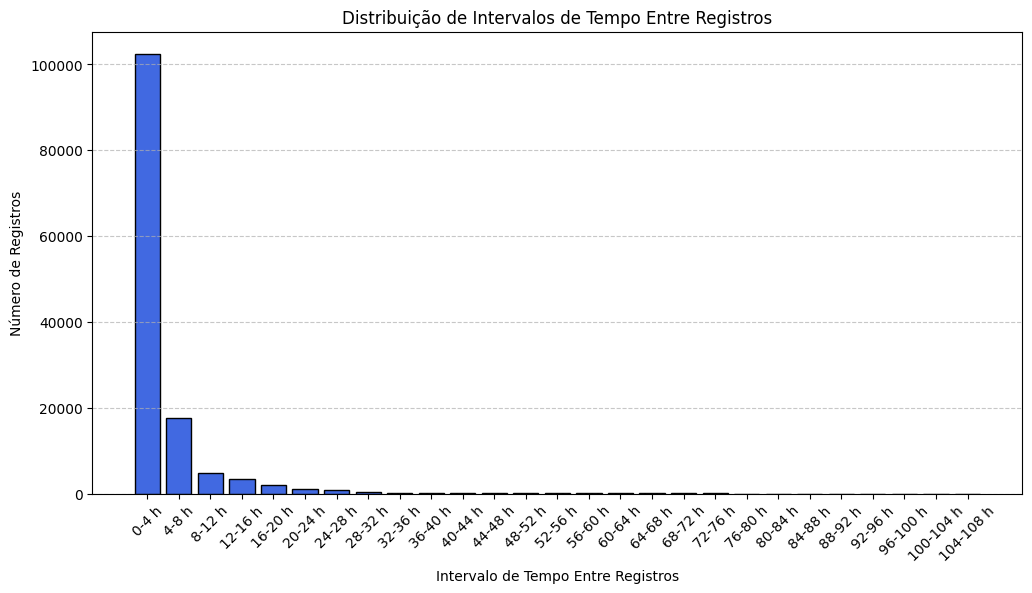

Média: 6.15 horas
Mediana: 1.98 horas
Máximo: 23882.17 horas


In [ ]:
# Criar cópia para análise de outliers
df_outliers = dados.copy()

# Ordenar os dados
df_outliers = df_outliers.sort_values(by=['individual.local.identifier (ID)', 'timestamp'])

# Calcular a diferença de tempo entre registros consecutivos
df_outliers['time_diff'] = df_outliers.groupby('individual.local.identifier (ID)')['timestamp'].diff().dt.total_seconds()

# Verificar se há timestamps fora de ordem
negativos = df_outliers[df_outliers['time_diff'] < 0]
if not negativos.empty:
    print("\n ALERTA: Foram encontrados timestamps fora de ordem! A corrigir...")
    df_outliers = df_outliers.sort_values(by=['individual.local.identifier (ID)', 'timestamp'])
    df_outliers['time_diff'] = df_outliers.groupby('individual.local.identifier (ID)')['timestamp'].diff().dt.total_seconds()

# Calcular outliers pelo método IQR
Q1 = df_outliers['time_diff'].quantile(0.25)
Q3 = df_outliers['time_diff'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_short = df_outliers[df_outliers['time_diff'] < lower_bound]
outliers_long = df_outliers[df_outliers['time_diff'] > upper_bound]

print(f"\n🔍 Total de outliers detectados no timestamp: {len(outliers_short) + len(outliers_long)}")
print(f"   - Intervalos muito curtos: {len(outliers_short)}")
print(f"   - Intervalos muito longos: {len(outliers_long)}")




# Visualizar a distribuição antes da correção
print("\n\033[1mTítulo: Distribuição dos Intervalos de Tempo Entre Registos antes de tratar outliers\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a distribuição dos intervalos de tempo entre registos antes da correção, para avaliar a dispersão e a presença de outliers.")

# Converter time_diff para horas
df_outliers['time_diff_hours'] = df_outliers['time_diff'] / 3600  # Converter para horas

# Definir os intervalos desejados (de 0 a 100h em passos de 4h)
bins = list(range(0, 110, 4))  # Criar bins de 4 em 4 horas até 100h

# Criar rótulos para os intervalos
labels = [f"{bins[i]}-{bins[i+1]} h" for i in range(len(bins)-1)]

# Criar categorias para os intervalos
df_outliers['interval_category'] = pd.cut(df_outliers['time_diff_hours'], bins=bins, labels=labels, right=False)

# Contar quantos registros existem em cada intervalo
df_frequencias = df_outliers['interval_category'].value_counts().sort_index()

# Criar um gráfico de barras
plt.figure(figsize=(12,6))
plt.bar(df_frequencias.index, df_frequencias.values, color='royalblue', edgecolor='black')
plt.xlabel("Intervalo de Tempo Entre Registros")
plt.ylabel("Número de Registros")
plt.title("Distribuição de Intervalos de Tempo Entre Registros")
plt.xticks(rotation=45)  # Rotacionar rótulos para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.show()

# Calcular estatísticas básicas
media = df_outliers['time_diff_hours'].mean()
mediana = df_outliers['time_diff_hours'].median()
maximo = df_outliers['time_diff_hours'].max()


print(f"Média: {media:.2f} horas")
print(f"Mediana: {mediana:.2f} horas")
print(f"Máximo: {maximo:.2f} horas")



####**Analise do gráfico**  
1. **Distribuição Extremamente Assimétrica:** A grande maioria dos intervalos está concentrada no primeiro bin (0-4 horas), indicando que os registos ocorrem com alta frequência nesse intervalo de tempo.
2. **Presença de Outliers:** Existem valores significativamente superiores a 4 horas, mas em menor quantidade. Estes podem ser considerados outliers.
3. **Queda Exponencial:** A contagem de registos diminui drasticamente à medida que os intervalos aumentam, sugerindo que grandes intervalos entre registos são menos comuns.
4. **Relação com a Qualidade dos Dados:** A presença de intervalos longos pode indicar eventos irregulares, falhas no registo de dados ou espaçamento natural entre certos eventos.


### **2.3.2 Tratar Outliers de timestamp**


 1. Remoção de registos com intervalos curtos  
- Eliminar registos identificados como intervalos de tempo anormalmente curtos.

 2. Interpolação de timestamps para intervalos longos  
- Aplicar interpolação linear aos timestamps de indivíduos que apresentam intervalos de tempo anormalmente longos.

 3. Substituição de valores atípicos pelo valor médio  
- Calcular a média dos intervalos de tempo (`time_diff`).  
- Substituir os intervalos de tempo que ultrapassam o limite superior pelo valor médio.

 4. Exibição dos resultados das correções  
- Apresentar a quantidade de registos removidos, interpolados e substituídos.

 5. Visualização da distribuição dos intervalos de tempo após a correção  
- Gerar um histograma para analisar a nova distribuição dos intervalos de tempo.


✅ Correções aplicadas nos outliers:
   - Registros removidos (intervalos curtos): 0
   - Registros interpolados (intervalos longos): 12883
   - Registros substituídos pelo valor médio: 12883

Título: Distribuição dos Intervalos de Tempo Após Correção
Objetivo: Avaliar a distribuição dos intervalos de tempo após a aplicação das correções, garantindo que os valores extremos foram mitigados e os dados estão mais consistentes.


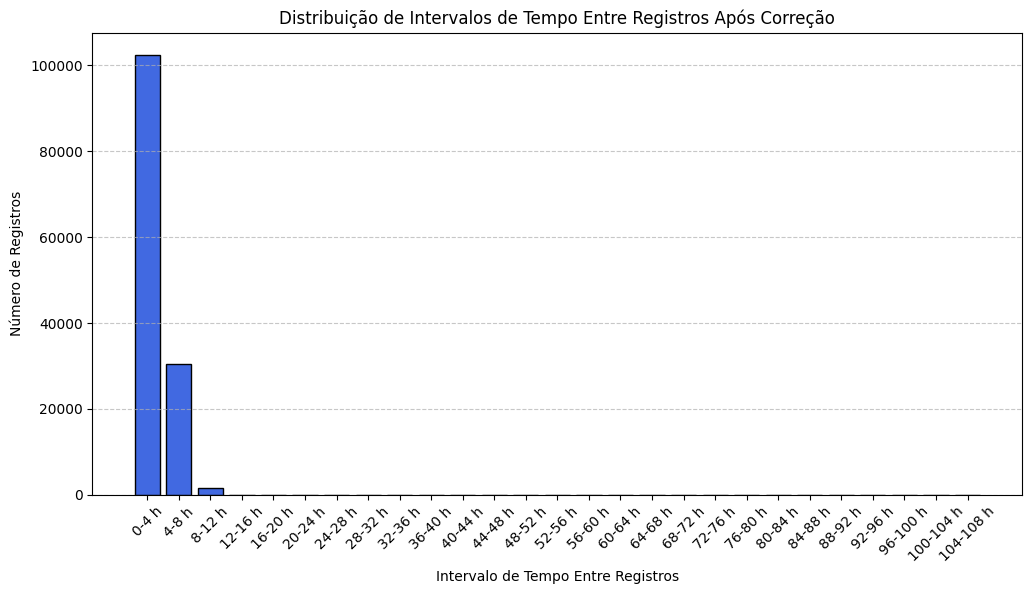

In [ ]:
# Aplicar correções automaticamente
df_outliers = df_outliers[~df_outliers.index.isin(outliers_short.index)]
removidos = len(outliers_short)

df_outliers['timestamp'] = df_outliers.groupby('individual.local.identifier (ID)')['timestamp'].transform(lambda x: x.interpolate())
interpolados = len(outliers_long)

media_time_diff = df_outliers['time_diff'].mean()
df_outliers.loc[df_outliers['time_diff'] > upper_bound, 'time_diff'] = media_time_diff
substituidos = len(df_outliers[df_outliers['time_diff'] == media_time_diff])

print(f"\n✅ Correções aplicadas nos outliers:")
print(f"   - Registros removidos (intervalos curtos): {removidos}")
print(f"   - Registros interpolados (intervalos longos): {interpolados}")
print(f"   - Registros substituídos pelo valor médio: {substituidos}\n")

# Visualizar a distribuição depois da correção
print("\033[1mTítulo: Distribuição dos Intervalos de Tempo Após Correção\033[0m")
print("\033[1mObjetivo:\033[0m Avaliar a distribuição dos intervalos de tempo após a aplicação das correções, garantindo que os valores extremos foram mitigados e os dados estão mais consistentes.")

# Converter `time_diff` para horas
df_outliers['time_diff_hours'] = df_outliers['time_diff'] / 3600

# Definir os intervalos desejados (de 0 a 100h em passos de 4h)
bins = list(range(0, 110, 4))  # Criar bins de 4 em 4 horas até 100h

# Criar rótulos para os intervalos
labels = [f"{bins[i]}-{bins[i+1]} h" for i in range(len(bins)-1)]

# Criar categorias para os intervalos
df_outliers['interval_category'] = pd.cut(df_outliers['time_diff_hours'], bins=bins, labels=labels, right=False)

# Contar quantos registros existem em cada intervalo
df_frequencias = df_outliers['interval_category'].value_counts().sort_index()

# Criar um gráfico de barras
plt.figure(figsize=(12,6))
plt.bar(df_frequencias.index, df_frequencias.values, color='royalblue', edgecolor='black')
plt.xlabel("Intervalo de Tempo Entre Registros")
plt.ylabel("Número de Registros")
plt.title("Distribuição de Intervalos de Tempo Entre Registros Após Correção")
plt.xticks(rotation=45)  # Rotacionar rótulos para melhor visualização
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar o gráfico
plt.show()


####**Análise do gráfico**  

<u>Diferenças Visíveis</u>:
- **Antes da correção:**
  - Existiam muitos valores dispersos ao longo de um amplo intervalo de tempo (incluindo valores extremos superiores a 50 horas).
  - A distribuição apresentava uma cauda longa, indicando a presença de outliers.

- **Depois da correção:**
  - A grande maioria dos registos ainda ocorre dentro do intervalo **0-4 horas**, mas a distribuição tornou-se mais concentrada.
  - Os registos com **intervalos muito longos foram ajustados**, reduzindo a dispersão e tornando os dados mais homogéneos.

<u>Impacto da Remoção dos Outliers</u>:
- A remoção dos outliers ajuda a **reduzir o efeito de eventos esporádicos e discrepantes**, melhorando a representatividade dos dados para análises futuras.
- A distribuição ficou **mais ajustada à realidade da maioria dos registos**, removendo possíveis erros ou anomalias.
- O comportamento principal dos dados não mudou: a maior parte dos registos ainda ocorre a cada **0-4 horas**, indicando que esse é realmente o padrão predominante.

 ### 2.3.3 Dataset com outliers de tempo tratado



In [ ]:
# 1. Criar cópia do dataset com outliers tratados**
dados_raw = df_outliers.copy()

#2. Remover colunas extras relacionadas ao tratamento de outliers**
dados_raw = dados_raw[dados.columns]  # Garantir que só as colunas originais de 'dados' sejam mantidas

# 3. Exibir o DataFrame final**
# Agora, 'df_cleaned' possui todas as colunas de 'dados' com os outliers tratados
print("\n📊 Dataset com outliers tratados, com apenas as colunas originais:")
print(tabulate(dados_raw.head(), headers='keys', tablefmt='grid')) # Exibindo as primeiras linhas para verificação
print(dados_raw.shape )


📊 Dataset com outliers tratados, com apenas as colunas originais:
+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+
|    |   Event_ID | timestamp           |   location.long |   location.lat | individual.taxon.canonical.name   | tag.local.identifier   |   individual.local.identifier (ID) | study.name   | country   |
+====+============+=====================+=================+================+===================================+========================+====================================+==============+===========+
|  0 |          1 | 2010-06-15 22:43:00 |        -58.0301 |       -23.3269 | Panthera onca                     | 0-333005               |                                  1 | Humid Chaco  | Paraguay  |
+----+------------+---------------------+-----------------+----------------+-----------------------------------+-------------

**Exportar o dataset tratato**

In [ ]:
dados_raw.to_csv("jaguar_movement_data_tratado.csv", index=False)  # Salva sem o índice
files.download("jaguar_movement_data_tratado.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**3. Análise do raw**

## 3.1 <u> Criar colunas de data </u>
O objetivo  é **extrair informações temporais detalhadas** da coluna `timestamp` e adicionar colunas separadas para facilitar análises temporais.



In [ ]:
dados_raw_finais = dados_raw.copy()

# **Criar as colunas para dia, mês, ano, hora e minuto**
dados_raw_finais['day'] = dados_raw_finais['timestamp'].dt.day
dados_raw_finais['month'] = dados_raw_finais['timestamp'].dt.month
dados_raw_finais['year'] = dados_raw_finais['timestamp'].dt.year
dados_raw_finais['hour'] = dados_raw_finais['timestamp'].dt.hour
dados_raw_finais['minute'] = dados_raw_finais['timestamp'].dt.minute

# **Exibir as primeiras linhas para verificação**
print("\n Dataset com colunas de dia, mês, ano, hora e minuto adicionadas:")
print(tabulate(dados_raw_finais.head(),headers='keys', tablefmt='grid'))
print(dados_raw_finais.shape)


 Dataset com colunas de dia, mês, ano, hora e minuto adicionadas:
+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+-------+---------+--------+--------+----------+
|    |   Event_ID | timestamp           |   location.long |   location.lat | individual.taxon.canonical.name   | tag.local.identifier   |   individual.local.identifier (ID) | study.name   | country   |   day |   month |   year |   hour |   minute |
+====+============+=====================+=================+================+===================================+========================+====================================+==============+===========+=======+=========+========+========+==========+
|  0 |          1 | 2010-06-15 22:43:00 |        -58.0301 |       -23.3269 | Panthera onca                     | 0-333005               |                                  1 | Humid Chaco

## 3.2 <u> Explorar o dataset bruto depois das atualizações

In [ ]:
#Exploração dos daods após o tratamento
print("\nResumo do Dataset:")
print(dados_raw_finais.info())
print('-'*50)
print("\nTamanho do Dataset:", dados_raw_finais.shape)
print('-'*50)
print("\nResumo Estatístico:")
print(tabulate(dados_raw_finais.describe(),headers='keys', tablefmt='grid'))
print('-'*50)

# Exibir primeiras linhas do dataset
print("\nAmostra dos Dados:")
print(tabulate(dados_raw_finais.head(), headers='keys', tablefmt='grid'))


Resumo do Dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 134690 entries, 0 to 134689
Data columns (total 14 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Event_ID                          134690 non-null  float64       
 1   timestamp                         134690 non-null  datetime64[ns]
 2   location.long                     134690 non-null  float64       
 3   location.lat                      134690 non-null  float64       
 4   individual.taxon.canonical.name   134690 non-null  object        
 5   tag.local.identifier              134690 non-null  object        
 6   individual.local.identifier (ID)  134690 non-null  int64         
 7   study.name                        134690 non-null  object        
 8   country                           134690 non-null  object        
 9   day                               134690 non-null  int32         
 10  month            

## 3.3 <u> Visualização dos dados

1. Identificação do número de indivíduos únicos  
  - Contabilizar o número de indivíduos distintos presentes no conjunto de  dados.  


2. Exibição dos diferentes casos em estudo  
  - Identificar e listar os diferentes **casos de estudo** disponíveis.  

3. Contagem do número de espécies únicas  
  - Determinar o número de espécies distintas incluídas na análise.  
  

4. Gerar gráfico de frequência para os casos em estudo  
  - Criar um gráfico de barras para visualizar a distribuição dos casos em  estudo.  


5. Gerar gráfico de frequência para os países  
  - Representar a distribuição geográfica dos   casos de estudo por país.  



Número de indivíduos diferentes: 117

Casos em estudo disponíveis:
['Humid Chaco' 'Atlantic forest' 'Jaguar_Taiama' 'jaguar_Oncafari Project'
 'Dry Chaco' 'IOP' 'Jaguar Conservation in the Caatinga Biome'
 'Costa Rica' 'Panthera_Pantanal-Jaguar-Project'
 'Jaguar Conservation in the Atlantic Forest'
 'Jaguar Conservation in Argentina' 'jaguar of sonora'
 'Greater Lacandona Ecosystem' 'Jaguar Mex' 'Pantanal'
 'Paraguayan Pantanal'
 "Jaguars' Movement Pattern in a fragmente landscape" 'Jaguar_Mamiraua'
 'Rio Negro' 'Sao Bento']

Número de espécies diferentes em estudo: 1


Título: Frequência dos Diferentes Casos em Estudo
Objetivo: Analisar a distribuição dos diferentes casos em estudo para identificar quais são mais recorrentes.


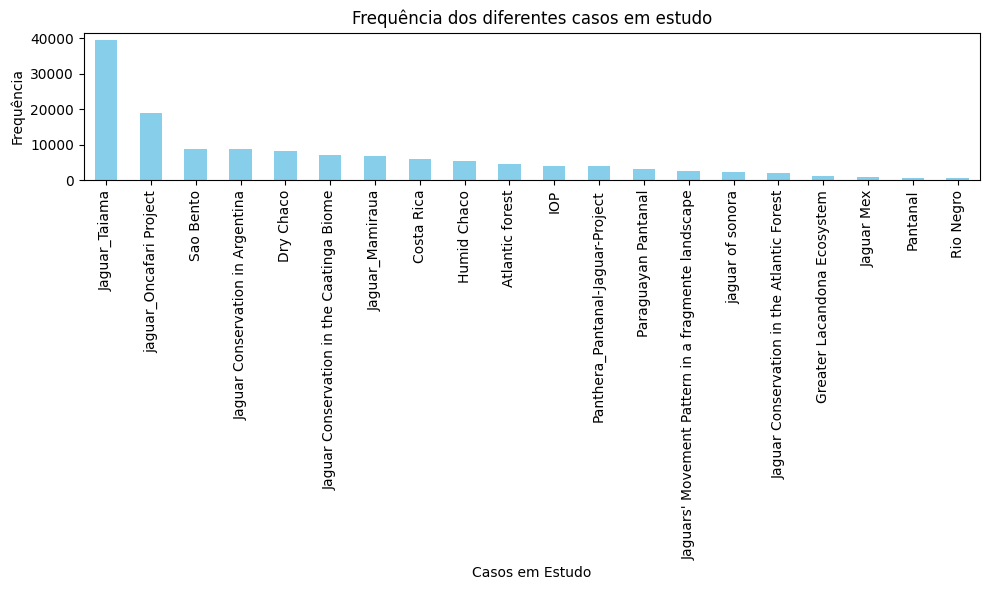



Título: Frequência dos Casos por País
Objetivo: Identificar a distribuição dos casos em estudo por país, analisando quais locais têm maior representação.


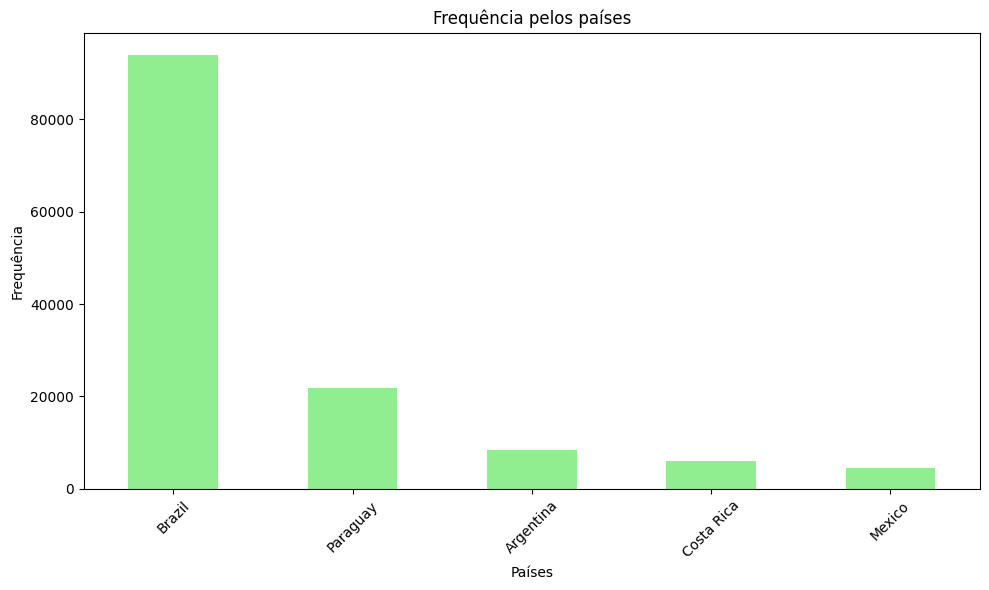

In [ ]:
#===========================================================================
# 1. Identificar o número de indivíduos únicos
#===========================================================================
num_individuos = dados_raw_finais['individual.local.identifier (ID)'].nunique()
print(f"Número de indivíduos diferentes: {num_individuos}")


#===========================================================================
# 2. Exibir os diferentes casos em estudo (valores únicos de study.name)
#===========================================================================
casos_estudo = dados_raw_finais['study.name'].unique()
print("\nCasos em estudo disponíveis:")
print(casos_estudo)

#===========================================================================
# 3. Contar o número de espécies únicas
#===========================================================================
num_especies = dados_raw_finais['individual.taxon.canonical.name'].nunique()
print(f"\nNúmero de espécies diferentes em estudo: {num_especies}")



#===========================================================================
# 4. Gerar gráfico de frequência para os casos em estudo
#===========================================================================

# Print na consola com título e objetivo
print("\n\n\033[1mTítulo: Frequência dos Diferentes Casos em Estudo\033[0m")
print("\033[1mObjetivo:\033[0m Analisar a distribuição dos diferentes casos em estudo para identificar quais são mais recorrentes.")

# Gerar o gráfico
plt.figure(figsize=(10, 6))
dados_raw_finais['study.name'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Frequência dos diferentes casos em estudo')
plt.xlabel('Casos em Estudo')
plt.ylabel('Frequência')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#===========================================================================
# 5. Gerar gráfico de frequência para os países
#===========================================================================

# Print na consola com título e objetivo
print("\n\n\033[1mTítulo: Frequência dos Casos por País\033[0m")
print("\033[1mObjetivo:\033[0m Identificar a distribuição dos casos em estudo por país, analisando quais locais têm maior representação.")

# Gerar o gráfico
plt.figure(figsize=(10, 6))
dados_raw_finais['country'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Frequência pelos países')
plt.xlabel('Países')
plt.ylabel('Frequência')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


####1. **Análise dos gráfico Frequência dos Diferentes Casos em Estudo:**  

  O presente gráfico apresenta a frequência de diferentes casos em estudo,  permitindo identificar quais os contextos mais representativos na análise.

**Observações Principais:**
  - O caso **"Jaguar_Taiama"** apresenta a maior frequência, destacando-se  significativamente em relação aos outros casos.
  - O **"Jaguar_Onçafari Project"** também possui uma quantidade relevante de   registos, embora bem abaixo do primeiro caso.
  - Os restantes casos possuem frequências muito menores, com uma distribuição  bastante desigual.
  - Casos como **"Rio Negro", "Pantanal" e "Jaguar Mex"** apresentam uma contagem   quase insignificante em comparação com os primeiros colocados.

**Implicações:**
  - A disparidade entre os casos indica que algumas áreas são mais estudadas ou   monitorizadas do que outras.
  - Pode ser necessário balancear os dados para evitar viés na análise e garantir   que todas as áreas tenham representação adequada.<br><br><br>


####2. **Análise dos gráfico Frequência dos casos pelos Países:**
  Este gráfico apresenta a distribuição da frequência dos registos por país,  permitindo identificar quais regiões possuem maior volume de dados.

  **Observações Principais**:
  - O **Brasil** apresenta a maior frequência de registos, destacando-se  amplamente em relação aos outros países.
  - O **Paraguai** aparece como o segundo país mais representado, mas com uma   quantidade significativamente menor de registos.
  - **Argentina, Costa Rica e México** apresentam uma frequência ainda menor,   indicando que nestas regiões há menos dados coletados.

**Implicações**:
  - A maior concentração de registos no Brasil pode indicar uma maior   disponibilidade de estudos e monitoramento na região.
  - Países com baixa frequência podem estar sub-representados, o que pode levar a   uma visão enviesada da análise geral.




### **3.3.1 Movimentação geografica dos animais**
  

1. Visualizar a movimentação dos animais
  - Criar um gráfico de dispersão com as **coordenadas GPS** (latitude e  longitude).  
  - Identificar padrões e possíveis anomalias na movimentação dos animais.  








Título: Movimentação Geográfica dos Animais (Após o Tratamento de Outliers)
Objetivo: Visualizar a movimentação geográfica dos animais após o tratamento de outliers, garantindo que os dados representem melhor os padrões reais de deslocamento.


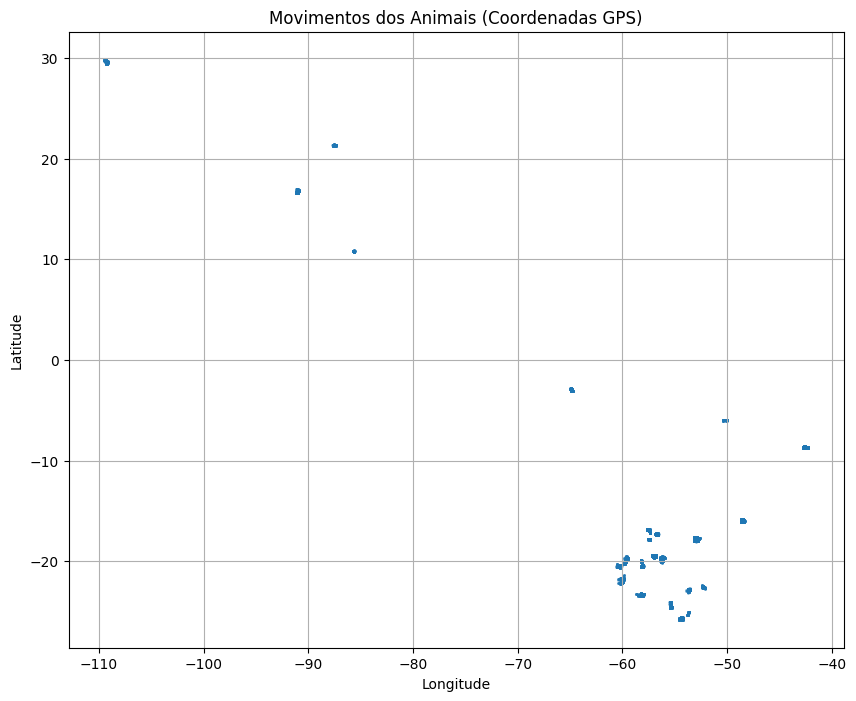

In [ ]:

#===========================================================================
# Movimentação geográfica dos animais
#===========================================================================

# Print na consola com título e objetivo
print("\n\n\033[1mTítulo: Movimentação Geográfica dos Animais (Após o Tratamento de Outliers)\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a movimentação geográfica dos animais após o tratamento de outliers, garantindo que os dados representem melhor os padrões reais de deslocamento.")

# Gerar o gráfico
plt.figure(figsize=(10, 8))
plt.scatter(dados_raw_finais['location.long'], dados_raw_finais['location.lat'], s=1, alpha=0.5)
plt.title('Movimentos dos Animais (Coordenadas GPS)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()


####**Análise do grafico do Movimentos dos Animais (Coordenadas GPS)**  
  Este gráfico representa as coordenadas geográficas dos movimentos dos animais.A análise permite avaliar a  distribuição espacial dos registos e verificar se houve remoção de outliers ou ajustes nos pontos capturados.

**Observações Principais:**                   
  - **Distribuição Geral:** Os pontos mantêm uma distribuição concentrada em  determinadas regiões, sugerindo áreas de maior atividade dos animais   monitorizados.
  - **Pontos Dispersos:** Alguns pontos continuam a aparecer distantes do   agrupamento principal, o que pode indicar deslocamentos reais e não   necessariamente outliers.
  - **Possível Identificação de Subgrupos:** A existência de pontos isolados pode   indicar populações distintas em habitats separados.

**Interpretação dos Dados:**
  - A presença de pontos afastados do centro pode indicar **subpopulações de  panteras-onças** localizadas em diferentes habitats.
  


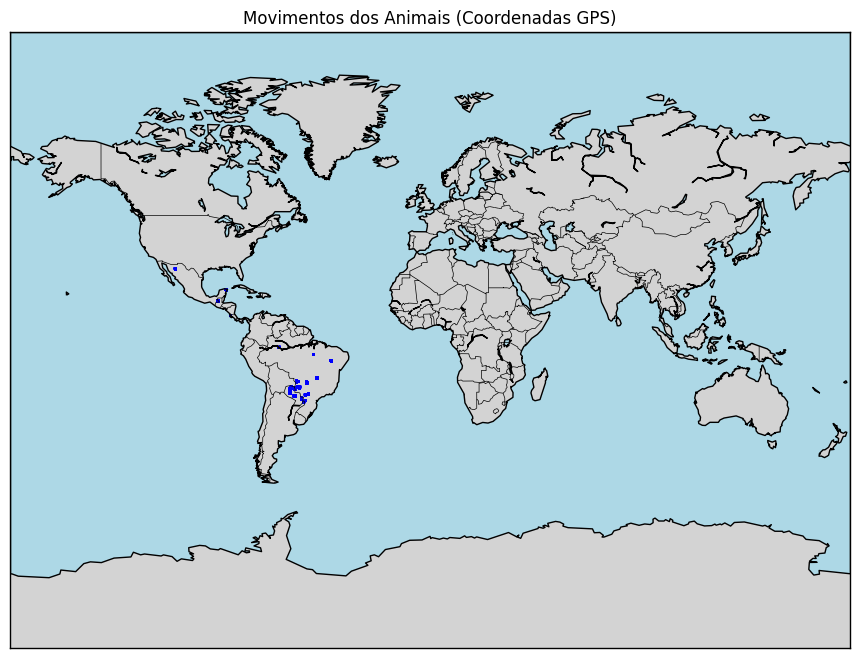

In [ ]:

#===========================================================================#
# Movimentação geográfica dos animais
#===========================================================================#

# Criando a figura
plt.figure(figsize=(12, 8))

# Criando o mapa novamente
m = Basemap(projection='mill', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180, resolution='c')
m.drawcoastlines()
m.drawcountries()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')

# Convertendo coordenadas para o mapa
x, y = m(dados_raw_finais['location.long'].values, dados_raw_finais['location.lat'].values)
plt.scatter(x, y, s=1, alpha=0.5, color='blue')

# Adicionando título
plt.title('Movimentos dos Animais (Coordenadas GPS)')
plt.show()


####**Analise do gráfico**

**Observações Principais**:
- **Concentração na América do Sul:** A maioria dos registos ocorre na região da **América do Sul**, particularmente no Brasil, Argentina e Paraguai, que são habitats naturais da Panthera onça.
- **Pontos isolados na América Central:** Existe um pequeno número de registos dispersos na região centro do continente Americano.
- **Distribuição Coerente:** A localização dos registos é consistente com os habitats naturais da Panthera onça, indicando que os dados refletem um padrão esperado de distribuição da espécie.

## 3. Interpretação dos Dados
- Os pontos na América Central podem representar dispersão natural da espécie, estudos adicionais ou movimentações atípicas, ou até mesmo erros do GPS.
- A ausência de registos fora das Américas pode indicar uma limitação na coleta de dados ou simplesmente a inexistência da espécie nesses locais.



### **3.3.2 Distribuição temporal dos registos**


1. Gerar gráfico da distribuição temporal  
  - Criar um gráfico de linha para visualizar a variação do número de registos.
  - Organizar os dados por data e contar a quantidade de registos em cada dia.  



Título: Distribuição Temporal dos Registos
Objetivo: Analisar a variação do número de registos ao longo do tempo para identificar tendências, padrões sazonais ou possíveis anomalias nos dados coletados.


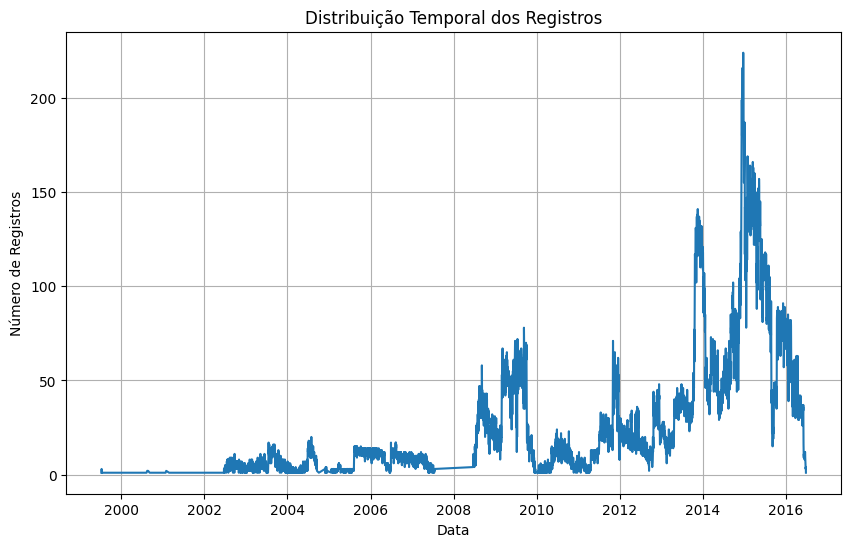

In [ ]:
# Print na consola com título e objetivo
print("\033[1mTítulo: Distribuição Temporal dos Registos\033[0m")
print("\033[1mObjetivo:\033[0m Analisar a variação do número de registos ao longo do tempo para identificar tendências, padrões sazonais ou possíveis anomalias nos dados coletados.")

# Gerar o gráfico
plt.figure(figsize=(10, 6))
dados_raw_finais['timestamp'].dt.date.value_counts().sort_index().plot(kind='line')
plt.title('Distribuição Temporal dos Registros')
plt.xlabel('Data')
plt.ylabel('Número de Registros')
plt.grid(True)
plt.show()

####**Análise do gráfico da Distribuição Temporal dos Registos**:

Este gráfico apresenta a distribuição temporal dos registos da **Panthera onça** ao longo dos anos. A visualização permite identificar padrões de coleta de dados, variações sazonais e possíveis períodos de maior ou menor atividade de monitorização.

**Observações Principais**:
- **Baixa frequência antes de 2002:** Nos primeiros anos, o número de registos era muito baixo, sugerindo que a coleta de dados era limitada ou inexistente.
- **Aumento gradual a partir de 2003:** Observa-se um crescimento na quantidade de registos ao longo do tempo, indicando um possível aumento no esforço de monitorização.
- **Picos entre 2012 e 2015:** Durante este período, há um aumento significativo no número de registos, atingindo o valor mais alto em torno de 2014.
- **Queda após 2015:** A partir de 2016, nota-se uma diminuição no número de registos, o que pode indicar mudanças na estratégia de coleta de dados ou no comportamento da espécie.



### **3.3.3. Analisar a quantidade de registos por id de animal**

1. Determinar o número total de animais monitorizados  
  - Contar o número de **identificadores únicos** dos animais no conjunto de  dados.  
  - Exibir o número total de animais presentes no estudo.  

2. Analisar a distribuição do número de registos por animal  
  - Contar a quantidade de registos por **ID de animal** para verificar a   distribuição dos dados.  
  - Ordenar os valores para identificar quais indivíduos têm mais ou menos  registos.  

3. Gerar gráfico da distribuição de registos por animal  
  - Criar um **gráfico de barras** para visualizar a quantidade de registos por   animal.  


4. Exibir os 10 animais com mais registos  
  - Listar os **10 animais** com maior número de registos para destacar os mais   monitorizados.  



Título: Número Total de Animais no Estudo
Objetivo: Determinar o número total de animais monitorados no estudo, analisando a quantidade de registros por animal para identificar padrões de rastreamento.

Número total de animais no estudo: 117

Título: Distribuição do Número de Registros por Animal
Objetivo: Analisar a distribuição dos registros por animal para identificar quais indivíduos têm mais ou menos dados coletados, permitindo inferências sobre o monitoramento.


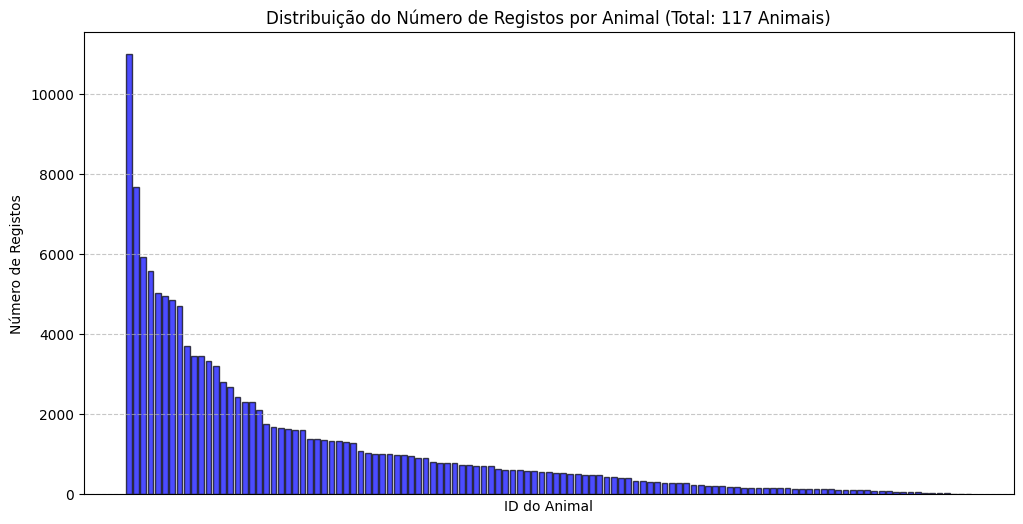


Top 10 animais com mais registros:
individual.local.identifier (ID)
81    10988
42     7668
26     5924
20     5590
13     5040
41     4952
84     4860
22     4709
99     3698
69     3464
dtype: int64


In [ ]:
# Print na consola com título e objetivo
print("\033[1mTítulo: Número Total de Animais no Estudo\033[0m")
print("\033[1mObjetivo:\033[0m Determinar o número total de animais monitorados no estudo, analisando a quantidade de registros por animal para identificar padrões de rastreamento.")

# Cálculo e exibição do número total de animais
num_animais = dados_raw_finais['individual.local.identifier (ID)'].nunique()
print(f"\nNúmero total de animais no estudo: {num_animais}")

#===========================================================================
# Distribuição do número de registros por animal
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição do Número de Registros por Animal\033[0m")
print("\033[1mObjetivo:\033[0m Analisar a distribuição dos registros por animal para identificar quais indivíduos têm mais ou menos dados coletados, permitindo inferências sobre o monitoramento.")

# Contagem de registros por ID
id_counts = dados_raw_finais.groupby('individual.local.identifier (ID)').size().sort_values(ascending=False)

# Criar o gráfico de barras para a distribuição de registros por animal
plt.figure(figsize=(12, 6))
plt.bar(id_counts.index.astype(str), id_counts.values, color='blue', alpha=0.7, edgecolor='black')
plt.title(f"Distribuição do Número de Registos por Animal (Total: {num_animais} Animais)")
plt.xlabel("ID do Animal")
plt.ylabel("Número de Registos")

plt.xticks([])  # Remover os rótulos do eixo X para mais clareza
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Exibir os primeiros 10 IDs com mais registros
print("\n\033[1mTop 10 animais com mais registros:\033[0m")
print(id_counts.head(10))

####**Análise do gráfico da Distribuição de Registos por Animal da Panthera Onça**
Este gráfico apresenta a distribuição do número de registos por animal individual da **Panthera onça**, permitindo identificar disparidades no volume de dados coletados para cada indivíduo monitorado.

**Observações Principais**:
- **Distribuição altamente assimétrica:** Alguns animais possuem um número muito maior de registos em comparação com outros.
- **Concentração de registos em poucos indivíduos:** O animal mais monitorado possui mais de **10.000 registos**, enquanto muitos outros apresentam menos de **1.000**.
- **Cauda longa na distribuição:** A quantidade de registos por animal diminui gradativamente, sugerindo que há indivíduos com poucos dados disponíveis.
- **Total de 117 animais monitorados:** Indica um esforço de coleta de dados distribuído entre diversas onças-pintadas, mas com forte variação na quantidade de registos individuais.

**Interpretação dos Dados**:
- A grande diferença no número de registos pode ser causada por **variações na disponibilidade de coletores GPS**, **tempo de rastreamento** ou **diferenças comportamentais entre indivíduos**.
- Animais com menos registos podem ter sido monitorados por períodos mais curtos, ou os dispositivos podem ter falhado em alguns casos.
- A concentração de dados em poucos indivíduos pode gerar um viés nos estudos, tornando necessário um balanceamento na coleta de dados.



## <u> 3.4 Codificar variavéis categoricas</u>





1. Conversão de variáveis categóricas para numéricas  
  - Aplicar **Label Encoding** para converter valores categóricos em números  inteiros, facilitando o processamento dos dados:  
    - Converter a coluna **study.name** e armazenar o mapeamento original.  
    - Converter a coluna **country** e armazenar o mapeamento original.  
    - Converter a coluna **individual.taxon.canonical.name** e armazenar o  mapeamento original.  

2. Exibição dos resultados  
  - Mostrar as primeiras linhas do dataset após a normalização e codificação.  
  - Exibir os **mapeamentos das variáveis categóricas**, garantindo que os  valores convertidos possam ser interpretados corretamente.  

In [ ]:

#=========================================================================
# Converter variáveis categóricas para numéricas usando One-Hot Encoding
#=========================================================================

# Inicializar o LabelEncoder
le = LabelEncoder()

# 1. Label Encoding para 'study.name'
dados_raw_finais['study.name'] = le.fit_transform(dados_raw_finais['study.name'])
study_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# 2. Label Encoding para 'country'
dados_raw_finais['country'] = le.fit_transform(dados_raw_finais['country'])
country_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# 3. Label Encoding para 'individual.taxon.canonical.name'
dados_raw_finais['individual.taxon.canonical.name'] = le.fit_transform(dados_raw_finais['individual.taxon.canonical.name'])
taxon_mapping = dict(zip(le.classes_, le.transform(le.classes_)))


# Exibir as primeiras linhas do dataset após a codificação
print("Primeiras linhas do dataset (head):")
print(tabulate(dados_raw_finais.head(), headers='keys', tablefmt='grid'))

# Exibir os mapeamentos separados
print("\nMapping dos estudos (study.name):")
print(study_mapping)
print("\nMapping dos países (country):")
print(country_mapping)
print("\nMapping das espécies (individual.taxon.canonical.name):")
print(taxon_mapping)



Primeiras linhas do dataset (head):
+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+-------+---------+--------+--------+----------+
|    |   Event_ID | timestamp           |   location.long |   location.lat |   individual.taxon.canonical.name | tag.local.identifier   |   individual.local.identifier (ID) |   study.name |   country |   day |   month |   year |   hour |   minute |
+====+============+=====================+=================+================+===================================+========================+====================================+==============+===========+=======+=========+========+========+==========+
|  0 |          1 | 2010-06-15 22:43:00 |        -58.0301 |       -23.3269 |                                 0 | 0-333005               |                                  1 |            4 |         4 |    15 |       6

#**4. Features Engineering**

## <u>4.1 Criar features derivadas</u>


1. Cálculo da diferença de tempo entre medições  
  - Ordenar os registos por **identificador do indivíduo** e **timestamp**.  
  - Calcular o **intervalo de tempo** entre medições consecutivas (em segundos).  

2. Cálculo da distância entre pontos geográficos  
  - Implementar a **fórmula de Haversine** para calcular a distância em metros  entre duas coordenadas GPS.  

3. Cálculo do ângulo de viragem  
  - Definir uma função para calcular o **ângulo de mudança de direção** entre   três pontos consecutivos.  
  - Utilizar **produto escalar** para determinar o ângulo e convertê-lo para  graus.  

4. Cálculo de velocidade, aceleração e ângulo de viragem  
  - Para cada registo, calcular:  
    - **Distância percorrida** entre medições consecutivas.  
    - **Velocidade média** baseada no tempo entre medições.  
    - **Aceleração** baseada na variação da velocidade.  
    - **Ângulo de viragem** para analisar mudanças de direção.  

5. Aplicação dos cálculos separadamente para cada indivíduo  
  - Aplicar as funções a cada **indivíduo** no conjunto de dados.  

6. Criar features baseadas no período do dia  
  - Categorizar os registos em **Madrugada, Manhã, Tarde ou Noite**, com base na  **hora do timestamp**.  



In [ ]:

dados_features = dados_raw_finais.copy()


# 1. Calcular a diferença de tempo entre medições consecutivas (em segundos)
dados_features = dados_features.sort_values(by=['individual.local.identifier (ID)', 'timestamp'])  # Ordenar por indivíduo e tempo
dados_features['time_diff'] = dados_features.groupby('individual.local.identifier (ID)')['timestamp'].diff().dt.total_seconds()

# 2. Função para calcular distância usando Haversine (em metros)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Raio da Terra em metros
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])  # Converter para radianos

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c  # Retorna distância em METROS

# 3. Função para calcular o ângulo de viragem entre três pontos consecutivos
def calcular_angulo(lat1, lon1, lat2, lon2, lat3, lon3):
    v1 = np.array([lat2 - lat1, lon2 - lon1])
    v2 = np.array([lat3 - lat2, lon3 - lon2])

    dot_product = np.dot(v1, v2)

    mag_v1 = np.linalg.norm(v1)
    mag_v2 = np.linalg.norm(v2)

    if mag_v1 == 0 or mag_v2 == 0:
        return np.nan

    cosine_angle = np.clip(dot_product / (mag_v1 * mag_v2), -1, 1)  # Garantir que está entre -1 e 1
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)  # Retorna ângulo em GRAUS

# 4. Aplicar cálculos para cada indivíduo
def calcular_features(dados_features):
    distancias = np.full(len(dados_features), np.nan)
    velocidades = np.full(len(dados_features), np.nan)
    aceleracoes = np.full(len(dados_features), np.nan)
    angulos = np.full(len(dados_features), np.nan)

    for i in range(1, len(dados_features)):
        lat1, lon1 = dados_features.iloc[i - 1][['location.lat', 'location.long']]
        lat2, lon2 = dados_features.iloc[i][['location.lat', 'location.long']]
        distancias[i] = haversine(lat1, lon1, lat2, lon2)

        tempo = dados_features.iloc[i]['time_diff']
        velocidades[i] = distancias[i] / tempo if tempo > 0 else np.nan  # Velocidade em m/s

        if i > 1:
            lat3, lon3 = dados_features.iloc[i - 2][['location.lat', 'location.long']]
            angulos[i] = calcular_angulo(lat3, lon3, lat1, lon1, lat2, lon2)

            vel_anterior = velocidades[i - 1]
            tempo_anterior = dados_features.iloc[i - 1]['time_diff']

            if tempo_anterior > 0 and not np.isnan(vel_anterior):
                aceleracoes[i] = (velocidades[i] - vel_anterior) / tempo_anterior
            else:
                aceleracoes[i] = np.nan

    dados_features['distance_m'] = distancias
    dados_features['speed_mps'] = velocidades
    dados_features['acceleration_mps2'] = aceleracoes
    dados_features['turning_angle'] = angulos

    return dados_features

# 5. Aplicar os cálculos separadamente por indivíduo
dados_features = dados_features.groupby('individual.local.identifier (ID)', group_keys=False).apply(calcular_features)

# 6. Criar a feature `time_period` baseada na hora do dia
def definir_periodo_do_dia(hora):
    if 0 <= hora < 6:
        return "Madrugada"
    elif 6 <= hora < 12:
        return "Manhã"
    elif 12 <= hora < 18:
        return "Tarde"
    else:
        return "Noite"

dados_features['time_period'] = dados_features['timestamp'].dt.hour.apply(definir_periodo_do_dia)

print (tabulate(dados_features.head(),headers='keys', tablefmt='grid'))


+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+-------+---------+--------+--------+----------+-------------+--------------+--------------+---------------------+-----------------+---------------+
|    |   Event_ID | timestamp           |   location.long |   location.lat |   individual.taxon.canonical.name | tag.local.identifier   |   individual.local.identifier (ID) |   study.name |   country |   day |   month |   year |   hour |   minute |   time_diff |   distance_m |    speed_mps |   acceleration_mps2 |   turning_angle | time_period   |
+====+============+=====================+=================+================+===================================+========================+====================================+==============+===========+=======+=========+========+========+==========+=============+==============+==============+==========

<ipython-input-20-73c039ce766e>:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_features = dados_features.groupby('individual.local.identifier (ID)', group_keys=False).apply(calcular_features)


### 4.1.1 Identificar e tratar outliers de localiização identificados acima

**Identificar**


1. Definição da função para cálculo de distância  
  - Implementar a fórmula de **Haversine** para calcular a distância entre duas   coordenadas geográficas.  
  - Utilizar o raio médio da Terra (6371 km ou 6.371.000 metros) para conversão.  

2. Cálculo da distância e velocidade  
  - Criar uma função que percorre o conjunto de dados e calcula:  
    - A distância entre registos consecutivos de um mesmo indivíduo.  
    - A velocidade baseada no tempo decorrido entre os registos.  
  - Criar novas colunas para armazenar os valores de **distância percorrida   (metros)** e **velocidade (m/s)**.  

3. Aplicação dos cálculos por indivíduo  
  - Aplicar os cálculos separadamente para cada indivíduo no conjunto de dados.  

4. Definição dos limites para deteção de outliers  
  - Estabelecer critérios para identificação de valores atípicos:  
    - Distâncias superiores a **20 km**.  
    - Velocidade superior a **30 km/h** como suspeita.  
    - Velocidade superior a **80 km/h** como erro claro.  

5. Identificação de outliers  
  - Filtrar os registos que excedem os limites definidos para:  
    - Distância percorrida.  
    - Velocidade suspeita.  
    - Velocidade excessiva.  

6. Exibição do resumo dos outliers detetados  
  - Apresentar a quantidade de registos identificados como outliers:  
    - Registos com distância superior a 20 km.  
    - Registos com velocidade superior a 30 km/h (suspeitos).  
    - Registos com velocidade superior a 80 km/h (erros claros).  



In [ ]:
# 3. Aplicar os cálculos separadamente por indivíduo

dados_features = dados_features.groupby('individual.local.identifier (ID)', group_keys=False).apply(calcular_features)
# 4. Definir os limites para detectar outliers
limite_distancia = 20000  # 20 km
limite_velocidade_suspeita = 8.3  # 30 km/h (m/s)
limite_velocidade_erro = 22  # 80 km/h (m/s)

# 5. Identificar outliers
outliers_distancia = dados_features[dados_features['distance_m'] > limite_distancia]
outliers_velocidade = dados_features[dados_features['speed_mps'] > limite_velocidade_suspeita]
outliers_velocidade_erro = dados_features[dados_features['speed_mps'] > limite_velocidade_erro]

# 6. Print de resumo dos outliers detectados
print(f"\n🔍 Total de outliers detectados:")
print(f"   - Distância maior que 20 km: {len(outliers_distancia)} registos")
print(f"   - Velocidade maior que 30 km/h (suspeitos): {len(outliers_velocidade)} registos")
print(f"   - Velocidade maior que 80 km/h (erros claros): {len(outliers_velocidade_erro)} registos")




🔍 Total de outliers detectados:
   - Distância maior que 20 km: 62 registos
   - Velocidade maior que 30 km/h (suspeitos): 1 registos
   - Velocidade maior que 80 km/h (erros claros): 0 registos


<ipython-input-21-4a9a3ea2aef4>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_features = dados_features.groupby('individual.local.identifier (ID)', group_keys=False).apply(calcular_features)


**Tratar**
  1. Remoção de registos com distância superior a 20 km  
    - Identificar os registos onde a distância percorrida entre pontos  consecutivos   seja superior a **20 km**.  
    - Contabilizar o número de registos removidos.  
    - Atualizar o conjunto de dados excluindo esses registos.  
  
  2. Remoção de registos com velocidade superior a 30 km/h  
    - Identificar os registos onde a velocidade calculada seja superior a **30 km/  h  (8.3 m/s)**.  
    - Contabilizar o número de registos removidos.  
    - Atualizar o conjunto de dados excluindo esses registos.  
  
  3. Exibição do resumo das correções aplicadas  
    - Apresentar a quantidade total de **outliers removidos**.  
    - Indicar quantos registos foram removidos por **distância excessiva**.  
    - Indicar quantos registos foram removidos por **velocidade excessiva**.  
  
  4. Exibição do número final de registos após a limpeza  
    - Apresentar a quantidade total de registos restantes no conjunto de dados  após   a remoção dos outliers.  
  

In [ ]:
# 7. Remover registros onde a distância for maior que 20 km
outliers_distancia = dados_features[dados_features['distance_m'] > 20000]  # 20 km
num_removidos_distancia = len(outliers_distancia)
dados_features = dados_features[~dados_features.index.isin(outliers_distancia.index)]

# 8. Remover registros com velocidade maior que 30 km/h (8.3 m/s)
outliers_velocidade = dados_features[dados_features['speed_mps'] > 8.3]  # 30 km/h
num_removidos_velocidade = len(outliers_velocidade)
dados_features = dados_features[~dados_features.index.isin(outliers_velocidade.index)]

# 9. Print final de registros restantes e resumo das correções aplicadas
print("\n📊 🔍 Resumo Final da Remoção de Outliers:")
print(f"✅ Total de outliers removidos: {num_removidos_distancia + num_removidos_velocidade}")
print(f"   - 🛑 Removidos por distância > 20 km: {num_removidos_distancia}")
print(f"   - ❌ Removidos por velocidade > 30 km/h: {num_removidos_velocidade}")

# 10. Print final de registros restantes
print(f"\n📊 Registros finais após limpeza: {len(dados_features)}")



📊 🔍 Resumo Final da Remoção de Outliers:
✅ Total de outliers removidos: 63
   - 🛑 Removidos por distância > 20 km: 62
   - ❌ Removidos por velocidade > 30 km/h: 1

📊 Registros finais após limpeza: 134627


In [ ]:
print("\n🔍 Verificação após remoção de outliers:")
print(f"Valores com distância > 20 km: {len(dados_features[dados_features['distance_m'] > 20000])}")
print(f"Valores com velocidade > 30 km/h: {len(dados_features[dados_features['speed_mps'] > 8.3])}")


🔍 Verificação após remoção de outliers:
Valores com distância > 20 km: 0
Valores com velocidade > 30 km/h: 0


##<u>4.2. Criar novas Features</u>

###**4.2.1 Adicionar idade e sexo de um dataset que contém a informação adicional**

In [ ]:


# Garantindo que ambas as colunas sejam do tipo object (string)
dados_features['individual.local.identifier (ID)'] = dados_features['individual.local.identifier (ID)'].astype(str)
additional_info['individual.local.identifier (ID)'] = additional_info['ID'].astype(str)

# Realizando o merge
dados_features = pd.merge(
    dados_features,
    additional_info[['individual.local.identifier (ID)', 'Sex', 'Estimated Age']],
    on='individual.local.identifier (ID)',
    how='left'
)

# Exibindo as primeiras linhas
print(tabulate(dados_features.head(),headers='keys', tablefmt='grid'))


+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+-------+---------+--------+--------+----------+-------------+--------------+--------------+---------------------+-----------------+---------------+-------+-----------------+
|    |   Event_ID | timestamp           |   location.long |   location.lat |   individual.taxon.canonical.name | tag.local.identifier   |   individual.local.identifier (ID) |   study.name |   country |   day |   month |   year |   hour |   minute |   time_diff |   distance_m |    speed_mps |   acceleration_mps2 |   turning_angle | time_period   |   Sex |   Estimated Age |
+====+============+=====================+=================+================+===================================+========================+====================================+==============+===========+=======+=========+========+========+==========+==

### **4.2.2. Adicionar a estação do Ano**

In [ ]:

# Definir estação do ano
def get_season(month):
    if month in [12, 1, 2]:
        return 'verão'
    elif month in [3, 4, 5]:
        return 'outono'
    elif month in [6, 7, 8]:
        return 'inverno'
    else:
        return 'primavera'

dados_features['season'] = dados_features['timestamp'].dt.month.apply(get_season)
print(tabulate(dados_features.head(), headers='keys', tablefmt='grid'))

+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+-------+---------+--------+--------+----------+-------------+--------------+--------------+---------------------+-----------------+---------------+-------+-----------------+----------+
|    |   Event_ID | timestamp           |   location.long |   location.lat |   individual.taxon.canonical.name | tag.local.identifier   |   individual.local.identifier (ID) |   study.name |   country |   day |   month |   year |   hour |   minute |   time_diff |   distance_m |    speed_mps |   acceleration_mps2 |   turning_angle | time_period   |   Sex |   Estimated Age | season   |
+====+============+=====================+=================+================+===================================+========================+====================================+==============+===========+=======+=========+========+

### **4.2.3 Gerar dados Climáticos**

1. Definir uma semente para reprodutibilidade  
  - Utilizar `np.random.seed(42)` para garantir que os valores gerados sejam  sempre os mesmos em diferentes execuções.  

2. Criar um novo conjunto de dados para os dados climáticos  
  - Copiar os dados originais (`dados_features`) para um novo DataFrame   (`dados_climaticos`).  

3. Gerar dados de temperatura  
  - Basear a **temperatura na latitude**, assumindo que locais mais distantes do  equador tendem a ser mais frios.  
  - Adicionar uma **variação aleatória** para simular condições reais.  
  - Garantir que os valores estejam dentro de um intervalo realista **(entre 15°C   e 40°C)**.  

4. Gerar dados  de precipitação  
  - Definir a **precipitação com base na latitude**:  
    - Regiões **tropicais (latitude < 23.5°)** recebem mais precipitação.  
    - Regiões **fora dos trópicos** tendem a ter menor precipitação.  
  - Garantir que os valores fiquem dentro de um intervalo realista.  

5. Gerar dados  de humidade  
  - Ajustar a **humidade com base na temperatura** (valores mais elevados de  temperatura reduzem a humidade).  
  - Incorporar a **precipitação** para influenciar a humidade.  
  - Limitar os valores para um intervalo realista **(entre 40% e 100%)**.  





In [ ]:
################################################################################
# Gerar Dados Climáticos
################################################################################

np.random.seed(42)  # Para reprodutibilidade

# Criar um novo DataFrame para os dados climáticos
dados_climaticos = dados_features.copy()

# Ajustar temperatura baseada na latitude e limitar valores realistas
dados_climaticos['temperature_realistic'] = 30 - (np.abs(dados_climaticos['location.lat']) * 0.15)
dados_climaticos['temperature_realistic'] += np.random.uniform(-5, 5, size=len(dados_climaticos)) # vamores aletaorio de ruido
dados_climaticos['temperature_realistic'] = dados_climaticos['temperature_realistic'].clip(lower=15, upper=40)

# Ajustar precipitação baseada na latitude e limitar valores realistas
dados_climaticos['precipitation_realistic'] = np.where(
    np.abs(dados_climaticos['location.lat']) < 23.5,
    np.random.uniform(5, 20, size=len(dados_climaticos)),# dentro dos tropicos, valores aleatórios de 5 a 20
    np.random.uniform(0, 10, size=len(dados_climaticos)) #fora dos tropicos, valores aleatório  de 0 a 10
)


# Ajustar umidade com base na temperatura e precipitação
dados_climaticos['humidity_realistic'] = 100 - (dados_climaticos['temperature_realistic'] - 20) * 1.5
dados_climaticos['humidity_realistic'] += dados_climaticos.get('precipitation_realistic', np.zeros(len(dados_climaticos))) * 3
dados_climaticos['humidity_realistic'] = dados_climaticos['humidity_realistic'].clip(lower=40, upper=100)



print(tabulate(dados_climaticos.head(), headers='keys', tablefmt='grid'))


+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+-------+---------+--------+--------+----------+-------------+--------------+--------------+---------------------+-----------------+---------------+-------+-----------------+----------+-------------------------+---------------------------+----------------------+
|    |   Event_ID | timestamp           |   location.long |   location.lat |   individual.taxon.canonical.name | tag.local.identifier   |   individual.local.identifier (ID) |   study.name |   country |   day |   month |   year |   hour |   minute |   time_diff |   distance_m |    speed_mps |   acceleration_mps2 |   turning_angle | time_period   |   Sex |   Estimated Age | season   |   temperature_realistic |   precipitation_realistic |   humidity_realistic |
+====+============+=====================+=================+===============

**Gerar dados climáticos usando um API**

In [ ]:
"""import time
import requests
import pandas as pd

# Constants
API_URL = "https://archive-api.open-meteo.com/v1/archive"
OUTPUT_CSV_PATH = "C:\\Users\\Pedro\\Desktop\\Pedro\\MachineLearning\\weather_data.csv"
RETRIES = 5
INITIAL_WAIT_TIME = 5
API_SLEEP_TIME = 3  # seconds

def fetch_weather_data(lat, lon, start_date, end_date, retries=RETRIES, wait_time=INITIAL_WAIT_TIME):
    """
"""
    Fetches weather data from the API for the given coordinates and date range.

    Args:
        lat (float): Latitude.
        lon (float): Longitude.
        start_date (str): Start date in 'YYYY-MM-DD' format.
        end_date (str): End date in 'YYYY-MM-DD' format.
        retries (int): Number of retries in case of rate limiting.
        wait_time (int): Initial wait time between retries.

    Returns:
        dict or None: JSON response from the API if successful, else None.
    """
    """
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
        "timezone": "auto",
        "format": "json"
    }

    for attempt in range(retries):
        response = requests.get(API_URL, params=params)
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:
            print(f"⚠️ Erro 429: Muitas requisições para ({lat}, {lon}). Tentando novamente em {wait_time} segundos...")
            time.sleep(wait_time)
            wait_time *= 2  # Increase wait time after each retry
        else:
            print(f"❌ Erro {response.status_code} ao buscar dados para ({lat}, {lon}).")
            return None

    print(f"⛔ Falha após {retries} tentativas para ({lat}, {lon}).")
    return None

def prepare_dataset(dados_features):
    """
    """
    Prepares the dataset by copying, parsing timestamps, and rounding coordinates.

    Args:
        dados_features (pd.DataFrame): Original dataset containing 'timestamp', 'location.lat', and 'location.long'.

    Returns:
        tuple: (df, min_date, max_date, coordinates)
            - df: Processed DataFrame with new rounded coordinate columns.
            - min_date: Earliest date found in the dataset (as string 'YYYY-MM-DD').
            - max_date: Latest date found in the dataset (as string 'YYYY-MM-DD').
            - coordinates: List of unique [lat_round, long_round] pairs.
    """
    """
    df = dados_features.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    # Determine the date range
    min_date = df["timestamp"].min().date().isoformat()
    max_date = df["timestamp"].max().date().isoformat()

    # Round coordinates to reduce API calls
    df["lat_round"] = df["location.lat"].round(2)
    df["long_round"] = df["location.long"].round(2)

    # Extract unique coordinate pairs
    grouped_locations = df.groupby(["lat_round", "long_round"]).size().reset_index(name="count")
    coordinates = grouped_locations[["lat_round", "long_round"]].values.tolist()

    return df, min_date, max_date, coordinates

def collect_weather_data(coordinates, start_date, end_date):
    """
    """
    Iterates over coordinates to collect weather data from the API.

    Args:
        coordinates (list): List of [lat, lon] pairs.
        start_date (str): Start date for API calls.
        end_date (str): End date for API calls.

    Returns:
        list: List of weather data dictionaries.
    """
    """
    weather_data = []
    total = len(coordinates)

    for i, (lat, lon) in enumerate(coordinates, start=1):
        print(f"🌍 Buscando dados para: ({lat}, {lon}) [{i}/{total}]")
        data = fetch_weather_data(lat, lon, start_date, end_date)

        if data and "daily" in data:
            daily = data["daily"]
            num_days = len(daily["time"])
            for j in range(num_days):
                weather_data.append({
                    "lat_round": lat,
                    "long_round": lon,
                    "date": daily["time"][j],
                    "temp_max": daily["temperature_2m_max"][j],
                    "temp_min": daily["temperature_2m_min"][j],
                    "precipitation": daily["precipitation_sum"][j]
                })
        else:
            print(f"⚠️ Nenhum dado retornado para ({lat}, {lon}).")

        time.sleep(API_SLEEP_TIME)

    return weather_data

def main():
    # Assume dados_features is already imported/loaded before this script runs.
    # For example: from df_grid import dados_features
    try:
        # Prepare the dataset
        _, start_date, end_date, coordinates = prepare_dataset(dados_features)
    except Exception as e:
        print("Erro ao preparar o dataset:", e)
        return

    # Collect weather data for all unique coordinates
    weather_data = collect_weather_data(coordinates, start_date, end_date)

    if weather_data:
        weather_df = pd.DataFrame(weather_data)
        weather_df.to_csv(OUTPUT_CSV_PATH, index=False)
        print("✅ Dados meteorológicos coletados e salvos com sucesso!")
    else:
        print("⚠️ Nenhum dado meteorológico foi coletado.")

if __name__ == '__main__':
    main()
"""

IndentationError: unexpected indent (<ipython-input-27-d4519d35b5c7>, line 28)

### **4.2.4. Gerar dados de terreno**

1. Criar um novo conjunto de dados para informações de terreno  
  - Copiar os dados climáticos (`dados_climaticos`) para um novo DataFrame  (`dados_terreno`).  

2. Derivar o tipo de vegetação com base na latitude e longitude  
  - Criar uma função que atribui um **tipo de vegetação** dependendo da   localização geográfica:  
    - **Floresta** para determinadas coordenadas.  
    - **Savana** em outra faixa de latitude e longitude.  
    - **Pântano** para regiões específicas.  
    - **Campo aberto** como categoria padrão.  

3. Derivar a elevação com base na latitude e longitude  
  - Criar uma função que estima a **elevação** do terreno usando um modelo  simplificado baseado na localização.  

4. Derivar a distância até a fonte de água mais próxima  
  - Criar uma função que calcula a **distância até um corpo de água** usando uma  relação matemática com latitude e longitude.  

5. Aplicar as funções para gerar as novas variáveis ambientais  
  - Criar novas colunas no DataFrame:  
    - **vegetation_type** (tipo de vegetação).  
    - **elevation** (elevação do terreno).  
    - **water_distance** (distância até a água).  

6. Exibir uma prévia dos dados  
  - Mostrar as primeiras linhas do dataset atualizado para verificar a  consistência dos dados gerados.  


In [ ]:
dados_terreno = dados_climaticos.copy()
# Função para derivar `vegetation_type` com base em latitude e longitude
def derivar_vegetation_type(lat, long):
    if -25 <= lat <= -20 and -60 <= long <= -55:
        return 'floresta'
    elif -30 <= lat <= -25 and -65 <= long <= -60:
        return 'savana'
    elif -15 <= lat <= -10 and -55 <= long <= -50:
        return 'pântano'
    else:
        return 'campo aberto'

# Função para derivar `elevation` com base em latitude e longitude
def derivar_elevation(lat, long):
    if -25 <= lat <= -20:
        return 150 + (lat + 25) * 10
    elif -30 <= lat <= -25:
        return 100 + (long + 65) * 5
    else:
       return 200

# Função para derivar `water_distance` com base em latitude e longitude
"""
def derivar_water_distance(lat, long):
    return abs(lat * long) % 5000
"""
def derivar_water_distance(lat, lon):
    """
    Simula uma distância aproximada até a água baseada na geografia da América do Sul.
    - Quanto mais perto do oceano e da Amazônia, menor a distância.
    - Quanto mais perto dos Andes, maior a distância.
    """
    # Regiões próximas ao oceano Atlântico e Amazônia → perto da água
    if lon > -50 or (-10 < lat < 5):
        return 0  # Muito perto da água

    # Regiões intermediárias (interior do Brasil, Argentina, Paraguai, Bolívia)
    elif lon > -65:
        return 1000  # Interior, distância média

    # Regiões andinas (Peru, Chile, Bolívia, Argentina)
    else:
        return 5000  # Montanhas, muito longe da água
# Atualizar o pipeline de geração de terrenos
dados_terreno = dados_climaticos.copy()

# Aplicar as funções para criar as variáveis ambientais
dados_terreno['vegetation_type'] = dados_terreno.apply(
    lambda row: derivar_vegetation_type(row['location.lat'], row['location.long']), axis=1
)
dados_terreno['elevation'] = dados_terreno.apply(
    lambda row: derivar_elevation(row['location.lat'], row['location.long']), axis=1
)
dados_terreno['water_distance'] = dados_terreno.apply(
    lambda row: derivar_water_distance(row['location.lat'], row['location.long']), axis=1
)

# Exibir uma amostra dos dados
print("\nDados de Terreno Atualizados com Consistência Geográfica:")
print(tabulate(dados_terreno.head(), headers='keys', tablefmt='grid'))



Dados de Terreno Atualizados com Consistência Geográfica:
+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+-------+---------+--------+--------+----------+-------------+--------------+--------------+---------------------+-----------------+---------------+-------+-----------------+----------+-------------------------+---------------------------+----------------------+-------------------+-------------+------------------+
|    |   Event_ID | timestamp           |   location.long |   location.lat |   individual.taxon.canonical.name | tag.local.identifier   |   individual.local.identifier (ID) |   study.name |   country |   day |   month |   year |   hour |   minute |   time_diff |   distance_m |    speed_mps |   acceleration_mps2 |   turning_angle | time_period   |   Sex |   Estimated Age | season   |   temperature_realistic |   precipitati

**Gerar dados de terreno usando uma API**

In [ ]:
"""
import time
import requests
import pandas as pd

# Constants
OUTPUT_CSV_PATH = "C:\\Users\\Pedro\\Desktop\\Pedro\\MachineLearning\\terrain_data.csv"
RETRIES = 5
INITIAL_WAIT_TIME = 5
API_SLEEP_TIME = 3  # seconds

# ---------------------------------------------
# Função para obter a elevação usando Open Elevation API
# ---------------------------------------------
def get_elevation(lat, lon, retries=RETRIES, wait_time=INITIAL_WAIT_TIME):
    url = "https://api.open-elevation.com/api/v1/lookup"
    params = {"locations": f"{lat},{lon}"}

    for attempt in range(retries):
        try:
            response = requests.get(url, params=params)
            if response.status_code == 200:
                results = response.json().get("results", [])
                if results:
                    return results[0].get("elevation")
                else:
                    print(f"⚠️ Nenhuma elevação retornada para ({lat}, {lon}).")
                    return None
            elif response.status_code == 429:
                print(f"⚠️ Erro 429: Muitas requisições para ({lat}, {lon}). Tentando novamente em {wait_time} segundos...")
                time.sleep(wait_time)
                wait_time *= 2
            else:
                print(f"❌ Erro {response.status_code} ao buscar elevação para ({lat}, {lon}).")
                return None
        except Exception as e:
            print(f"❌ Exceção ao buscar elevação para ({lat}, {lon}): {e}")
            return None
    print(f"⛔ Falha após {retries} tentativas para ({lat}, {lon}).")
    return None

# ---------------------------------------------
# Função para obter o tipo de vegetação usando Overpass API
# ---------------------------------------------
def get_vegetation_type(lat, lon, radius=1000):
    """
"""
    Consulta o Overpass API em um raio (em metros) em torno do ponto para encontrar
    elementos que indiquem vegetação (ex: natural=wood ou landuse=forest).
    Retorna o valor da tag encontrada ou "desconhecido" se não encontrar.
    """

"""
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
"""
    [out:json];
    (
      node(around:{radius},{lat},{lon})[natural=wood];
      way(around:{radius},{lat},{lon})[landuse=forest];
      way(around:{radius},{lat},{lon})[natural=wood];
      relation(around:{radius},{lat},{lon})[landuse=forest];
    );
    out center 1;
    """
"""
    try:
        response = requests.get(overpass_url, params={"data": query})
        data = response.json()
        elements = data.get("elements", [])
        if elements:
            for el in elements:
                tags = el.get("tags", {})
                if "natural" in tags:
                    return tags["natural"]
                if "landuse" in tags:
                    return tags["landuse"]
            return "desconhecido"
        else:
            return "desconhecido"
    except Exception as e:
        print(f"❌ Erro na consulta Overpass para vegetação em ({lat}, {lon}): {e}")
        return "desconhecido"

# ---------------------------------------------
# Função para obter a distância até o corpo d'água mais próximo usando Overpass API
# ---------------------------------------------
def get_water_distance(lat, lon, radius=5000):
    """
"""
    Consulta o Overpass API para encontrar corpos d'água (tags natural=water ou waterway)
    dentro de um raio (em metros) e retorna a menor distância (em km) entre o ponto e o corpo d'água.
    """
"""
    overpass_url = "http://overpass-api.de/api/interpreter"
    query = f"""
"""
    [out:json];
    (
      node(around:{radius},{lat},{lon})[natural=water];
      way(around:{radius},{lat},{lon})[natural=water];
      way(around:{radius},{lat},{lon})[waterway=river];
      way(around:{radius},{lat},{lon})[waterway=stream];
      relation(around:{radius},{lat},{lon})[natural=water];
    );
    out center;
    """
"""
    try:
        response = requests.get(overpass_url, params={"data": query})
        data = response.json()
        elements = data.get("elements", [])
        if not elements:
            return None

        distances = []
        origin = (lat, lon)
        for el in elements:
            if "lat" in el and "lon" in el:
                point = (el["lat"], el["lon"])
            elif "center" in el:
                point = (el["center"]["lat"], el["center"]["lon"])
            else:
                continue
            # Calcula distância em quilômetros (você pode usar outra biblioteca se desejar)
            from geopy.distance import geodesic
            d = geodesic(origin, point).kilometers
            distances.append(d)

        if distances:
            return min(distances)
        else:
            return None
    except Exception as e:
        print(f"❌ Erro na consulta Overpass para água em ({lat}, {lon}): {e}")
        return None

# ---------------------------------------------
# Prepara o dataset agrupando por coordenadas arredondadas para 1 casa decimal
# ---------------------------------------------
def prepare_dataset(dados_features):
    """
"""
    Prepara o dataset copiando, convertendo timestamps e arredondando as coordenadas para 1 casa decimal.

    Args:
        dados_features (pd.DataFrame): Dataset original contendo 'timestamp', 'location.lat' e 'location.long'.

    Returns:
        tuple: (df, coordinates)
            - df: DataFrame com colunas originais e as colunas 'lat_round' e 'long_round'.
            - coordinates: Lista de pares únicos [lat_round, long_round].
    """
"""
    df = dados_features.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

    # Arredonda as coordenadas para 1 casa decimal
    df["lat_round"] = df["location.lat"].round(1)
    df["long_round"] = df["location.long"].round(1)

    # Extrai pares únicos de coordenadas
    grouped_locations = df.groupby(["lat_round", "long_round"]).size().reset_index(name="count")
    coordinates = grouped_locations[["lat_round", "long_round"]].values.tolist()

    return df, coordinates

# ---------------------------------------------
# Coleta dados de terreno para cada par único de coordenadas
# ---------------------------------------------
def collect_terrain_data(coordinates):
"""
"""
    Itera sobre as coordenadas únicas para coletar dados de terreno: elevação, tipo de vegetação
    e distância até o corpo d'água.

    Args:
        coordinates (list): Lista de pares [lat_round, long_round].

    Returns:
        list: Lista de dicionários com os dados de terreno para cada par de coordenadas.
"""
"""
    terrain_data = []
    total = len(coordinates)

    for i, (lat, lon) in enumerate(coordinates, start=1):
        print(f"🌍 Buscando dados de terreno para: ({lat}, {lon}) [{i}/{total}]")

        elevation = get_elevation(lat, lon)
        vegetation = get_vegetation_type(lat, lon, radius=1000)
        water_distance = get_water_distance(lat, lon, radius=5000)

        terrain_data.append({
            "lat_round": lat,
            "long_round": lon,
            "elevation": elevation,
            "vegetation_type": vegetation,
            "water_distance_km": water_distance
        })

        time.sleep(API_SLEEP_TIME)

    return terrain_data

# ---------------------------------------------
# Função principal: carrega o dataset, prepara as coordenadas, coleta dados de terreno e exporta para CSV
# ---------------------------------------------
def main():
    # Caminho do CSV de entrada (ajuste conforme necessário)
    input_csv_path = "C:\\Users\\Pedro\\Desktop\\Pedro\\MachineLearning\\dados_tratados.csv"
    # Caminho do CSV de saída
    output_csv_path = "C:\\Users\\Pedro\\Desktop\\Pedro\\MachineLearning\\terrain_data.csv"

    try:
        dados_features = pd.read_csv(input_csv_path, low_memory=False)
        print("✅ Dataset carregado com sucesso!")
    except Exception as e:
        print("Erro ao carregar o dataset:", e)
        return

    try:
        _, coordinates = prepare_dataset(dados_features)
        print(f"Número de coordenadas únicas: {len(coordinates)}")
    except Exception as e:
        print("Erro ao preparar o dataset:", e)
        return

    terrain_data = collect_terrain_data(coordinates)

    if terrain_data:
        terrain_df = pd.DataFrame(terrain_data)
        terrain_df.to_csv(output_csv_path, index=False)
        print("✅ Dados de terreno coletados e salvos com sucesso!")
    else:
        print("⚠️ Nenhum dado de terreno foi coletado.")

if __name__ == '__main__':
    main()

"""

'\n    terrain_data = []\n    total = len(coordinates)\n\n    for i, (lat, lon) in enumerate(coordinates, start=1):\n        print(f"🌍 Buscando dados de terreno para: ({lat}, {lon}) [{i}/{total}]")\n\n        elevation = get_elevation(lat, lon)\n        vegetation = get_vegetation_type(lat, lon, radius=1000)\n        water_distance = get_water_distance(lat, lon, radius=5000)\n\n        terrain_data.append({\n            "lat_round": lat,\n            "long_round": lon,\n            "elevation": elevation,\n            "vegetation_type": vegetation,\n            "water_distance_km": water_distance\n        })\n\n        time.sleep(API_SLEEP_TIME)\n\n    return terrain_data\n\n# ---------------------------------------------\n# Função principal: carrega o dataset, prepara as coordenadas, coleta dados de terreno e exporta para CSV\n# ---------------------------------------------\ndef main():\n    # Caminho do CSV de entrada (ajuste conforme necessário)\n    input_csv_path = "C:\\Users\\Ped

### **4.2.5 Criar os rotulos**

1. Criar um novo conjunto de dados para rótulos de movimento  
  - Copiar os dados de terreno (`dados_terreno`) para um novo DataFrame   (`dados_rotulos`).  

2. Definir categorias de movimento com base na velocidade  
  - Criar uma função para classificar os animais de acordo com a **velocidade   média (m/s)**:  
    - **Indefinido** → Quando a velocidade está ausente.  
    - **Parado** → Velocidade menor que **0.01 m/s**.  
    - **A caminhar** → Entre **0.01 m/s e 0.05 m/s**.  
    - **A correr** → Entre **0.05 m/s e 0.1 m/s**.  
    - **Sprint/Fuga** → Acima de **0.1 m/s**.  

3. Aplicar a classificação ao conjunto de dados  
  - Criar a coluna **movement_category** com as classificações atribuídas.  

4. Identificar e listar registros classificados como 'Indefinido'  
  - Filtrar e armazenar registos onde a velocidade não está disponível.  

5. Contar e exibir a distribuição das categorias de movimento  
  - Apresentar a frequência de cada categoria de movimento para análise.  

6. Exibir uma prévia do dataset atualizado  
  - Mostrar as primeiras linhas do DataFrame atualizado (`dados_rotulos`) para  verificar as classificações.  


In [ ]:
dados_rotulos= dados_terreno.copy()

# Criar rótulos de movimento


def classify_movement(speed):
    if pd.isna(speed):
        return 'Indefinido'
    elif speed < 0.01:
        return 'Parado'
    elif 0.01 <= speed < 1.5:
        return 'A caminhar'
    elif 1.5 <= speed < 8:
        return 'A correr'
    else:
        return 'Sprint/Fuga'

# Aplicar a classificação
dados_rotulos['movement_category'] = dados_rotulos['speed_mps'].apply(classify_movement)

# Exibir os registros onde o movimento foi classificado como 'Indefinido'
indefinidos = dados_rotulos[dados_rotulos['movement_category'] == 'Indefinido']

# Contagem de categorias
print("\nDistribuição das categorias de movimento:")
print(dados_rotulos['movement_category'].value_counts())


print(tabulate(dados_rotulos.head(), headers='keys', tablefmt='grid'))


Distribuição das categorias de movimento:
movement_category
Parado        70919
A caminhar    63531
Indefinido      117
A correr         60
Name: count, dtype: int64
+----+------------+---------------------+-----------------+----------------+-----------------------------------+------------------------+------------------------------------+--------------+-----------+-------+---------+--------+--------+----------+-------------+--------------+--------------+---------------------+-----------------+---------------+-------+-----------------+----------+-------------------------+---------------------------+----------------------+-------------------+-------------+------------------+---------------------+
|    |   Event_ID | timestamp           |   location.long |   location.lat |   individual.taxon.canonical.name | tag.local.identifier   |   individual.local.identifier (ID) |   study.name |   country |   day |   month |   year |   hour |   minute |   time_diff |   distance_m |    speed_mps |   

## 4.3. <u>Analise de feature engineering


In [ ]:
dados_updated=dados_rotulos.copy()

### 4.3.1  **Análise da Distancia**


  - **Objetivo:** Compreender a distribuição das distâncias percorridas entre registros consecutivos.

  - **Importância:** Distâncias anormalmente altas podem ser outliers ou indicar problemas de coleta de dados (como saltos de GPS).


**Inicialmente determinamos a distância máxima encontrada para definir o intervalo máximo de procura no gráfico**

In [ ]:
def obter_distancia_maxima(dados_updated):

    # Garante que não temos NaN nem inf, mas se você já trata isso no seu fluxo,
    # pode remover ou adaptar conforme necessário.
    distancias_validas = dados_updated['distance_m'].replace([np.inf, -np.inf], np.nan).dropna()

    if distancias_validas.empty:
        # Se não há valores válidos, podemos retornar zero ou algum valor de fallback.
        return 0.0

    return distancias_validas.max()

# Exemplo de uso (supondo que 'dados_features' já esteja com 'distance' calculada):
if __name__ == "__main__":
    # Vamos supor que você já tenha 'dados_features' com 'distance':
    dist_max = obter_distancia_maxima(dados_updated)
    print(f"A distância máxima encontrada no dataset (entre pontos consecutivos) é: {dist_max} metros.")

A distância máxima encontrada no dataset (entre pontos consecutivos) é: 19960.144479556144 metros.


Título: Análise da Distância Entre Registros Consecutivos
Objetivo: Examinar a distribuição das distâncias percorridas entre registros consecutivos para identificar padrões de movimentação e detectar possíveis outliers.

Resumo estatístico da coluna 'distance_m':
count    134510.000000
mean        583.878303
std        1419.534103
min           0.000000
25%          10.615786
50%          49.120681
75%         557.768318
max       19960.144480
Name: distance_m, dtype: float64

Título: Distribuição da Distância Entre Registros
Objetivo: Visualizar a distribuição da distância percorrida entre registros consecutivos para entender a variabilidade dos deslocamentos.


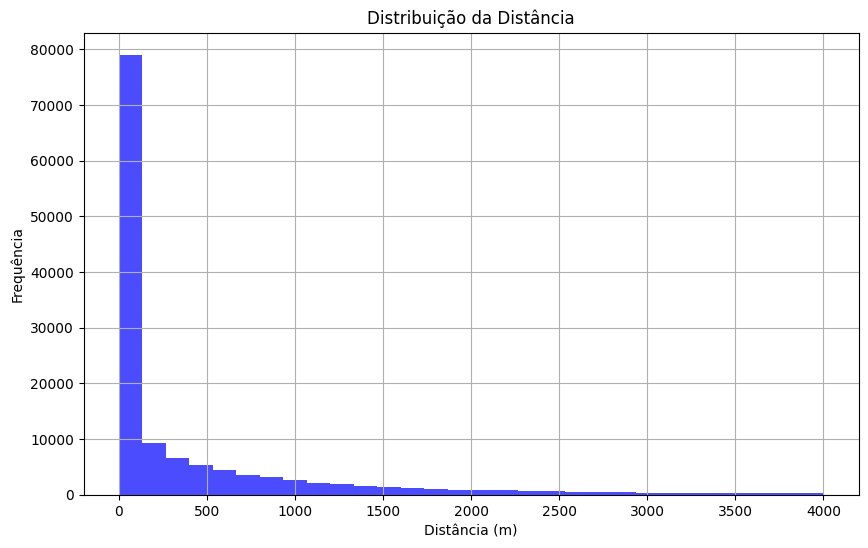

In [ ]:
#===========================================================================
# Análise da Distância Entre Registros Consecutivos
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise da Distância Entre Registros Consecutivos\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a distribuição das distâncias percorridas entre registros consecutivos para identificar padrões de movimentação e detectar possíveis outliers.")

# Exibir resumo estatístico da distância
print("\n\033[1mResumo estatístico da coluna 'distance_m':\033[0m")
print(dados_updated['distance_m'].describe())

#===========================================================================
# Visualização da Distribuição da Distância
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição da Distância Entre Registros\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a distribuição da distância percorrida entre registros consecutivos para entender a variabilidade dos deslocamentos.")

# Gerar histograma da distribuição da distância
plt.figure(figsize=(10, 6))
dados_updated['distance_m'].hist(bins=30, alpha=0.7, color='blue', range=(0, 4000))
plt.title('Distribuição da Distância')
plt.xlabel('Distância (m)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


####**Análise do gráfico da Distribuição da Distância Percorrida pela Panthera Onça**

Este gráfico apresenta a distribuição das distâncias percorridas entre registos consecutivos da **Panthera onça**, permitindo avaliar os deslocamentos da espécie ao longo do tempo.

**Observações Principais**:
- **Distribuição altamente assimétrica:** A maioria dos deslocamentos é de curta distância, com um grande número de registos abaixo de **500 metros**.
- **Cauda longa na distribuição:** Distâncias maiores são menos frequentes, mas ainda existem registos de deslocamentos superiores a **3000 metros**.
- **Pico significativo próximo de 0 metros:** Isso pode indicar momentos em que os animais permaneceram parados ou com deslocamento mínimo entre medições.

**Interpretação dos Dados**:
- A predominância de curtas distâncias sugere que a Panthera onça tem períodos frequentes de atividade reduzida ou patrulhamento em áreas restritas.
- Os deslocamentos mais longos podem estar associados a busca por presas, fuga de predadores, ou exploração de novos territórios.
- O padrão observado pode ser influenciado pelo intervalo de tempo entre registos, já que intervalos menores tendem a captar mais deslocamentos curtos.




###**4.3.3. Análise da velocidade**


  - **Objetivo**: Examinar o comportamento da velocidade média.

  - **Importância**: Ajuda a identificar padrões de movimento dos animais, como períodos de alta velocidade (possível caça/fuga) ou baixa velocidade (descanso).

**Identificamos a velocidade máxima para definirmos o intevalo máximo para o gráfico**

In [ ]:

def obter_velocidade_maxima(dados_features):
    """
        Valor máximo da coluna 'speed' no dataset.
    """
    # Substitui valores infinitos por NaN e remove registros faltantes,
    # caso existam dados corrompidos.
    velocidades_validas = dados_updated['speed_mps'].replace([np.inf, -np.inf], np.nan).dropna()

    if velocidades_validas.empty:
        # Se não há valores válidos, podemos retornar zero ou outro valor de fallback.
        return 0.0

    return velocidades_validas.max()


# Exemplo de uso (supondo que 'dados_features' já esteja com 'speed' calculada):
if __name__ == "__main__":
    vel_max = obter_velocidade_maxima(dados_updated)
    print(f"A velocidade máxima encontrada no dataset (entre pontos consecutivos) é: {vel_max} m/s.")


A velocidade máxima encontrada no dataset (entre pontos consecutivos) é: 4.703000206951511 m/s.


Título: Análise da Velocidade Média Calculada
Objetivo: Examinar a distribuição da velocidade média dos animais para identificar padrões de deslocamento e detectar possíveis outliers ou anomalias nos dados.

Resumo estatístico da coluna 'speed_mps':
count    134510.000000
mean          0.056466
std           0.121504
min           0.000000
25%           0.002040
50%           0.008143
75%           0.056443
max           4.703000
Name: speed_mps, dtype: float64

Título: Distribuição da Velocidade Média
Objetivo: Visualizar a distribuição da velocidade média dos animais para entender melhor sua mobilidade e variação ao longo do tempo.


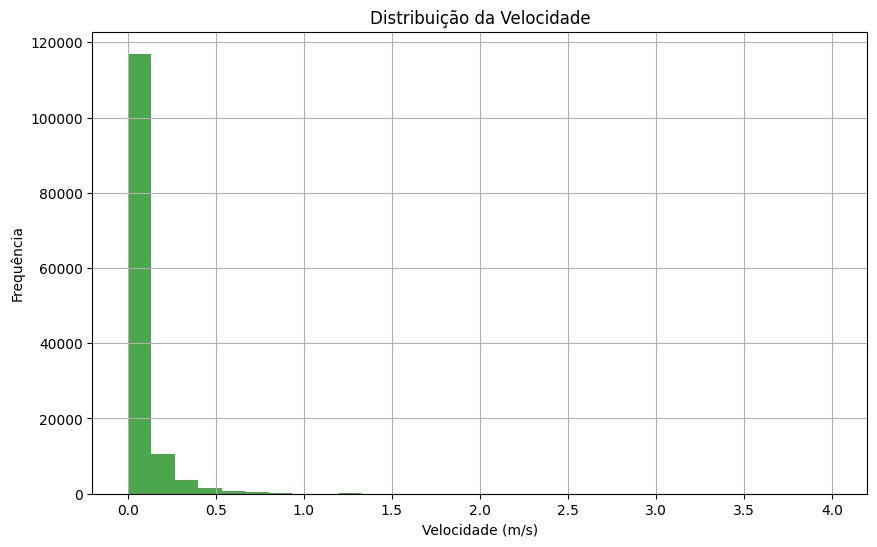

In [ ]:
#===========================================================================
# Análise da Velocidade Média Calculada
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise da Velocidade Média Calculada\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a distribuição da velocidade média dos animais para identificar padrões de deslocamento e detectar possíveis outliers ou anomalias nos dados.")

# Exibir resumo estatístico da velocidade
print("\n\033[1mResumo estatístico da coluna 'speed_mps':\033[0m")
print(dados_updated['speed_mps'].describe())

#===========================================================================
# Visualização da Distribuição da Velocidade
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição da Velocidade Média\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a distribuição da velocidade média dos animais para entender melhor sua mobilidade e variação ao longo do tempo.")

# Gerar histograma da distribuição da velocidade
plt.figure(figsize=(10, 6))
dados_features['speed_mps'].hist(bins=30, alpha=0.7, color='green', range=(0, 4))
plt.title('Distribuição da Velocidade')
plt.xlabel('Velocidade (m/s)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


####**Análise do gráfico da Distribuição da Velocidade da Panthera Onça**

Este gráfico apresenta a distribuição das velocidades registradas para a **Panthera onça**, permitindo avaliar os padrões de movimentação e comportamento da espécie.

**Observações Principais**:
- **Distribuição altamente assimétrica:** A maioria dos registos apresenta velocidades muito baixas, com um grande número de valores próximos de **0 m/s**.
- **Cauda longa na distribuição:** Embora a maioria das observações esteja concentrada em velocidades baixas, existem alguns casos de deslocamentos mais rápidos.
- **Pico significativo em velocidades próximas de 0 m/s:** Isso indica momentos de inatividade ou movimentação muito lenta.

**Interpretação dos Dados**:
- A predominância de velocidades reduzidas sugere que a Panthera onça passa grande parte do tempo em repouso ou movimentando-se de forma lenta.
- Os valores mais altos, embora menos frequentes, podem estar associados a deslocamentos rápidos em busca de presas ou fugas.
- A baixa velocidade média pode ser reflexo do intervalo fixo entre registos, que pode não capturar picos momentâneos de alta velocidade.


###**4.3.4. Análise do Turning Angle**


  - **Objetivo**: Observar as mudanças de direção realizadas pelos animais.

  - **Importância**: Mudanças frequentes de direção (ângulos altos) podem indicar comportamentos específicos, como exploração ou busca por alimentos.


Título: Análise do Turning Angle (Mudança de Direção)
Objetivo: Examinar a distribuição do turning angle para entender os padrões de mudança de direção dos animais e identificar comportamentos de deslocamento.

Resumo estatístico da coluna 'turning_angle':
count    133964.000000
mean         92.192237
std          56.180693
min           0.000000
25%          40.526597
50%          92.458418
75%         144.732775
max         180.000000
Name: turning_angle, dtype: float64

Título: Distribuição do Turning Angle
Objetivo: Visualizar a distribuição das mudanças de direção para identificar padrões de deslocamento e possíveis tendências comportamentais.


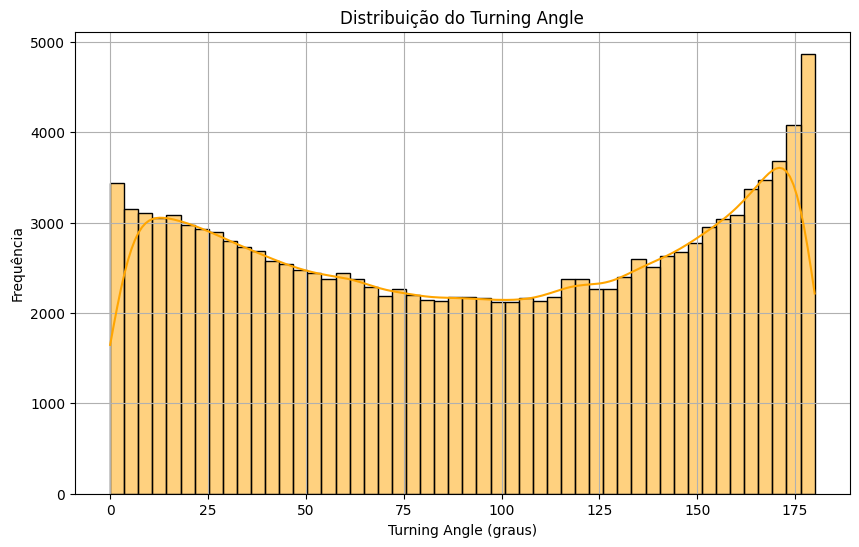

In [ ]:
#===========================================================================
# Análise do Turning Angle (Mudança de Direção)
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise do Turning Angle (Mudança de Direção)\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a distribuição do turning angle para entender os padrões de mudança de direção dos animais e identificar comportamentos de deslocamento.")

# Exibir resumo estatístico do turning angle
print("\n\033[1mResumo estatístico da coluna 'turning_angle':\033[0m")
print(dados_updated['turning_angle'].describe())

#===========================================================================
# Visualização da Distribuição do Turning Angle
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição do Turning Angle\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a distribuição das mudanças de direção para identificar padrões de deslocamento e possíveis tendências comportamentais.")

# Gerar histograma da distribuição do turning angle
plt.figure(figsize=(10, 6))
sns.histplot(dados_updated['turning_angle'], bins=50, kde=True, color='orange')
plt.title('Distribuição do Turning Angle')
plt.xlabel('Turning Angle (graus)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


#### **Análise da Distribuição do Ângulo de Mudança de Direção da Panthera Onça**
Este gráfico apresenta a distribuição do **ângulo de mudança de direção** da **Panthera onça**, permitindo avaliar os padrões de deslocamento e estratégia de movimentação da espécie.

**Observações Principais**:
- **Distribuição bimodal:** Há dois picos significativos em torno de **0° e 180°**, sugerindo que os animais frequentemente seguem trajetórias retilíneas ou fazem curvas fechadas.
- **Menor frequência em ângulos médios (50° a 130°):** Indica que mudanças moderadas de direção são menos comuns.
- **Maior concentração em ângulos extremos:** A Panthera onça tende a seguir percursos lineares ou realizar grandes mudanças de direção em seus deslocamentos.

**Interpretação dos Dados**:
- A predominância de ângulos próximos de **0°** sugere que os indivíduos frequentemente mantêm a direção, possivelmente ao se deslocarem por trilhas ou rotas conhecidas.
- O aumento na frequência de ângulos próximos de **180°** pode indicar mudanças bruscas de direção, que podem estar relacionadas a estratégias de caça ou evasão.
- A menor ocorrência de ângulos intermediários pode sugerir que a movimentação da espécie segue padrões de exploração e perseguição bem definidos.



###**4.3.5. Análise da variação da velocidade**


  - **Objetivo:** Explorar mudanças na velocidade entre registros consecutivos.
  
  - **Importância:** Ajuda a entender transições rápidas entre estados comportamentais (ex: de descanso para caça).


Título: Análise da Variação de Velocidade
Objetivo: Examinar a distribuição da variação de velocidade dos animais para identificar padrões de aceleração e desaceleração, bem como possíveis comportamentos distintos.

Resumo estatístico da coluna 'acceleration_mps2':
count    1.343930e+05
mean    -1.721544e-05
std      3.903259e-04
min     -5.732279e-02
25%     -1.473556e-06
50%      1.117987e-09
75%      1.386001e-06
max      1.210872e-02
Name: acceleration_mps2, dtype: float64

Título: Distribuição da Variação de Velocidade
Objetivo: Visualizar a distribuição da aceleração e desaceleração para entender padrões de movimentação e detectar possíveis anomalias ou comportamentos específicos.


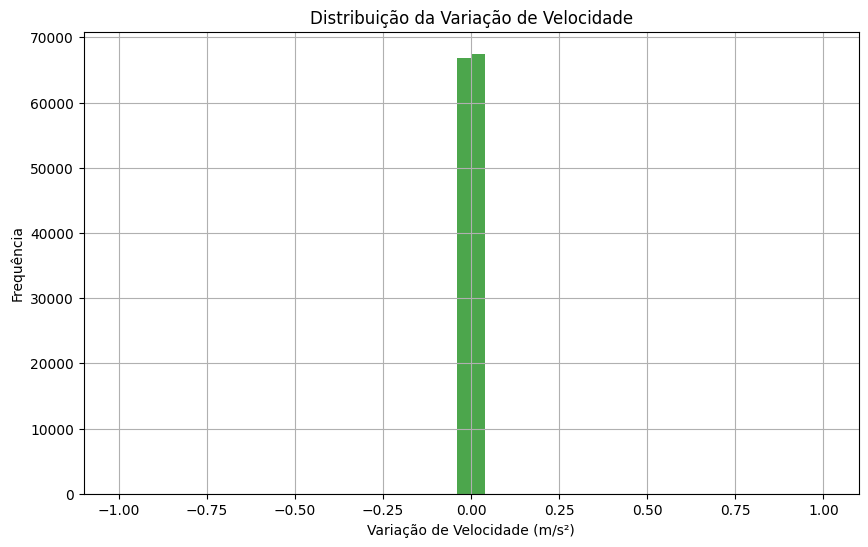

In [ ]:
#===========================================================================
# Análise da Variação de Velocidade
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise da Variação de Velocidade\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a distribuição da variação de velocidade dos animais para identificar padrões de aceleração e desaceleração, bem como possíveis comportamentos distintos.")

# Exibir resumo estatístico da variação de velocidade
print("\n\033[1mResumo estatístico da coluna 'acceleration_mps2':\033[0m")
print(dados_updated['acceleration_mps2'].describe())

#===========================================================================
# Visualização da Distribuição da Variação de Velocidade
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição da Variação de Velocidade\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a distribuição da aceleração e desaceleração para entender padrões de movimentação e detectar possíveis anomalias ou comportamentos específicos.")

# Gerar histograma da distribuição da variação de velocidade
plt.figure(figsize=(10, 6))
dados_updated['acceleration_mps2'].hist(bins=50, alpha=0.7, color='green', range=(-1,1))
plt.title('Distribuição da Variação de Velocidade')
plt.xlabel('Variação de Velocidade (m/s²)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


####**Análise do gráfico Distribuição da Variação de Velocidade da Panthera Onça**

Este gráfico apresenta a distribuição da **variação de velocidade** da **Panthera onça**, permitindo avaliar mudanças no padrão de deslocamento da espécie ao longo do tempo.

**Observações Principais**:
- **Distribuição extremamente concentrada em torno de 0 m/s²:** A maioria dos registos apresenta variações de velocidade muito pequenas ou nulas.
- **Ausência de grandes acelerações ou desacelerações:** O padrão sugere que os animais mantêm velocidades constantes na maior parte do tempo.
- **Faixa de variação muito estreita:** A distribuição indica pouca mudança nos ritmos de deslocamento.

**Interpretação dos Dados**:
- A concentração em **0 m/s²** sugere que a Panthera onça realiza deslocamentos em velocidade estável, sem acelerações bruscas.
- A ausência de valores extremos pode ser explicada por intervalos de amostragem uniformes, que podem não captar variações súbitas.
- O comportamento pode indicar patrulhamento territorial ou deslocamento em ambientes previsíveis.


###**4.3.6. Análise de Periodos do dia**


  - **Objetivo**: Examinar quando os registros ocorrem ao longo do dia.

  - **Importância**: Pode revelar padrões temporais, como maior atividade durante a madrugada ou descanso durante o dia.

Título: Análise da Distribuição dos Períodos do Dia
Objetivo: Examinar a frequência dos registros em diferentes períodos do dia para identificar padrões diários de atividade dos animais.

Distribuição dos períodos do dia:
time_period
Madrugada    38343
Manhã        35961
Tarde        31810
Noite        28513
Name: count, dtype: int64

Título: Distribuição dos Períodos do Dia
Objetivo: Visualizar a distribuição dos registros ao longo dos períodos do dia para entender os momentos de maior e menor atividade.


<ipython-input-38-ef5e385f756c>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='time_period', data=dados_updated, palette='coolwarm')


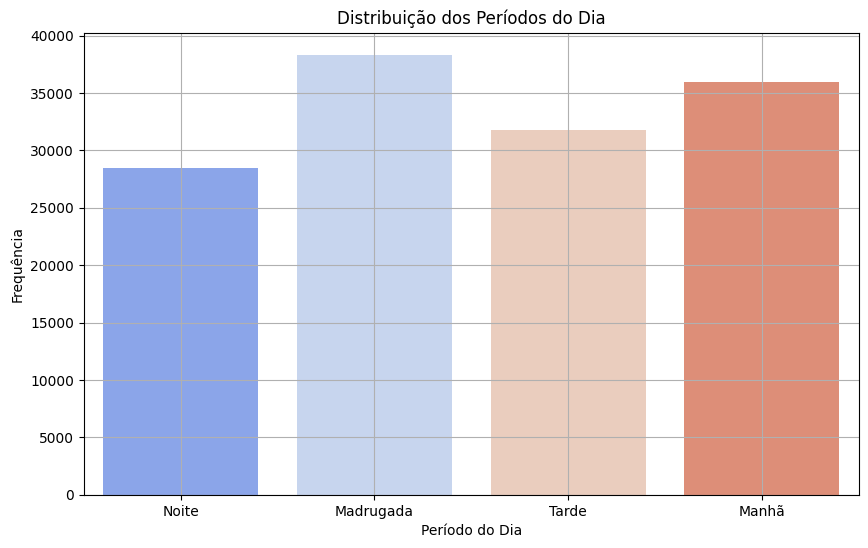

In [ ]:
#===========================================================================
# Análise da Distribuição dos Períodos do Dia
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise da Distribuição dos Períodos do Dia\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a frequência dos registros em diferentes períodos do dia para identificar padrões diários de atividade dos animais.")

# Exibir distribuição dos períodos do dia
print("\n\033[1mDistribuição dos períodos do dia:\033[0m")
print(dados_updated['time_period'].value_counts())

#===========================================================================
# Visualização da Distribuição dos Períodos do Dia
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição dos Períodos do Dia\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a distribuição dos registros ao longo dos períodos do dia para entender os momentos de maior e menor atividade.")

# Gerar gráfico da distribuição dos períodos do dia
plt.figure(figsize=(10, 6))
sns.countplot(x='time_period', data=dados_updated, palette='coolwarm')
plt.title('Distribuição dos Períodos do Dia')
plt.xlabel('Período do Dia')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


#### **Análise do grafico da Distribuição dos resgistos ao longo do dia**
Este gráfico apresenta a distribuição dos registos da **Panthera onça** ao longo dos diferentes períodos do dia, permitindo avaliar os momentos de maior atividade.

**Observações Principais**:
- **Maior número de registos durante a madrugada:** Indica que a Panthera onça apresenta alta atividade nesse período.
- **Manhã e tarde com quantidades equilibradas:** Os registos na manhã e na tarde são similares, sugerindo uma atividade moderada.
- **Menor frequência à noite:** Embora a espécie seja parcialmente noturna, os registos na noite são os menores em comparação com os outros períodos.

**Interpretação dos Dados**:
- A maior atividade durante a **madrugada** reforça a hipótese de que a Panthera onça apresenta um comportamento **crepuscular e noturno**, com maior deslocamento nesse intervalo.
- A quantidade considerável de registos durante a **manhã e a tarde** sugere que o animal pode ter picos de atividade intercalados ao longo do dia.
- A menor frequência de registos à noite pode indicar períodos de descanso ou uma possível limitação na coleta de dados nesse horário.





###**4.3.7. Análise das Estações do Ano**


  - **Objetivo**: Compreender a distribuição dos registros por estação do ano.

  - **Importância**: Pode indicar mudanças comportamentais sazonais, como migração ou busca por alimentos.

Título: Análise da Distribuição das Estações do Ano
Objetivo: Examinar a frequência dos registros em cada estação do ano para identificar padrões sazonais na movimentação dos animais.

Distribuição das estações do ano:
season
verão        36869
primavera    33674
outono       32933
inverno      31151
Name: count, dtype: int64

Título: Distribuição das Estações do Ano
Objetivo: Visualizar a distribuição dos registros ao longo das estações para entender variações sazonais na atividade dos animais.


<ipython-input-39-04cb374e7d81>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='season', data=dados_updated, palette='viridis')


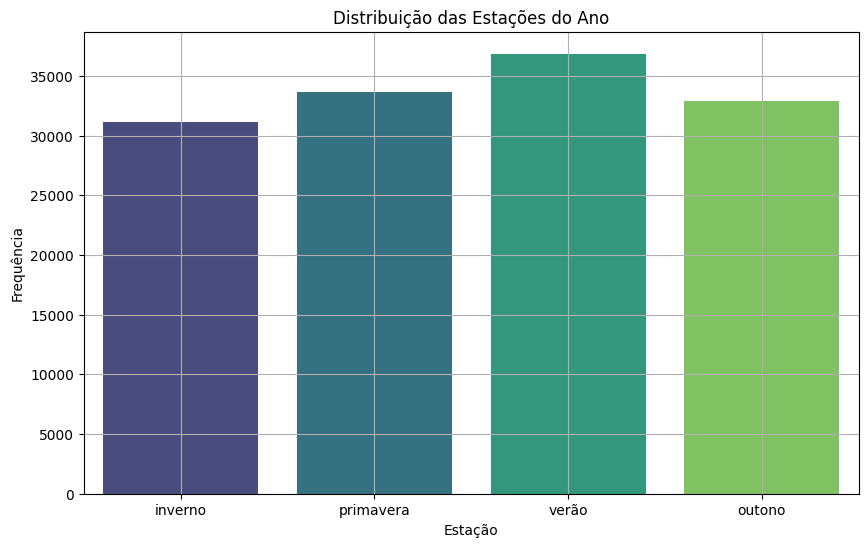

In [ ]:
#===========================================================================
# Análise da Distribuição das Estações do Ano
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise da Distribuição das Estações do Ano\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a frequência dos registros em cada estação do ano para identificar padrões sazonais na movimentação dos animais.")

# Exibir distribuição das estações do ano
print("\n\033[1mDistribuição das estações do ano:\033[0m")
print(dados_updated['season'].value_counts())

#===========================================================================
# Visualização da Distribuição das Estações do Ano
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição das Estações do Ano\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a distribuição dos registros ao longo das estações para entender variações sazonais na atividade dos animais.")

# Gerar gráfico da distribuição das estações
plt.figure(figsize=(10, 6))
sns.countplot(x='season', data=dados_updated, palette='viridis')
plt.title('Distribuição das Estações do Ano')
plt.xlabel('Estação')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


####**Análise da Distribuição dos registos pelas Estações do Ano**

Este gráfico apresenta a distribuição dos registos da **Panthera onça** ao longo das diferentes estações do ano, permitindo avaliar padrões sazonais de atividade.

**Observações Principais**:
- **Maior número de registos no verão:** O número de registos atinge seu pico durante esta estação, sugerindo maior atividade ou maior facilidade de monitoramento.
- **Distribuição relativamente equilibrada nas outras estações:** Primavera, outono e inverno apresentam quantidades similares de registos, com pequenas variações.
- **Menor frequência no inverno:** Embora a diferença não seja extrema, o inverno apresenta ligeiramente menos registos em comparação com as outras estações.

**Interpretação dos Dados**:
- O aumento no número de registos no **verão** pode estar relacionado a fatores ambientais, como maior disponibilidade de presas ou condições climáticas favoráveis à movimentação.
- A leve redução no inverno pode ser consequência de mudanças comportamentais, onde os animais reduzem sua atividade para conservar energia.
- A coleta de dados também pode ser influenciada por condições meteorológicas, como chuvas e neblina, que podem afetar a detecção e o rastreamento da espécie.




###**4.3.8. Análise da idade e sexo**


- **Objetivo**: Analisar a distribuição das variáveis Estimated Age e Sex no dataset para entender melhor a composição da população estudada.

- **Importância**: A idade e o sexo dos animais podem influenciar os seus padrões de movimentação, comportamento e resposta a fatores ambientais.

Título: Análise da Distribuição das Variável Catgórica Sex:
Objetivo: Examinar a frequência das variável Sex para identificar padrões e possíveis tendências nos dados.
Sex
Male      49730
Female    41511
Name: count, dtype: int64


<ipython-input-40-d1a34e801b1f>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dados_copia[col], palette="viridis")


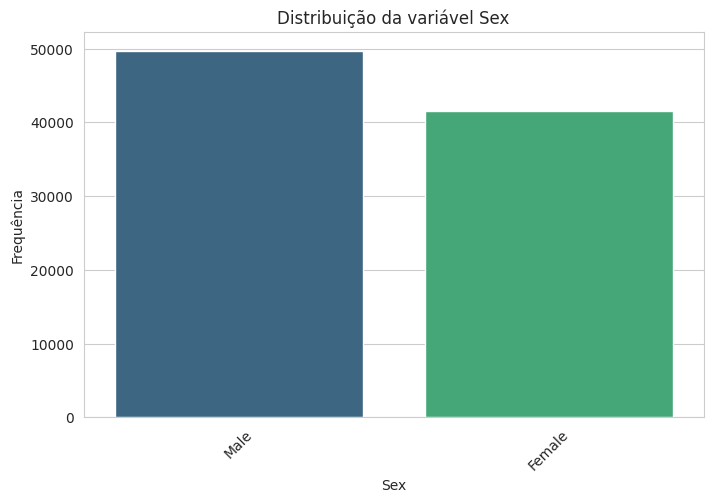


Título: Análise da Distribuição das Variável Estimated_Age
Objetivo: Examinar a distribuição das variável Estimated_Age para entender melhor a dispersão dos valores e detectar possíveis outliers.

Resumo estatístico da variável: Estimated Age
count    91223.000000
mean         5.700843
std          2.270372
min          1.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         11.000000
Name: Estimated Age, dtype: float64


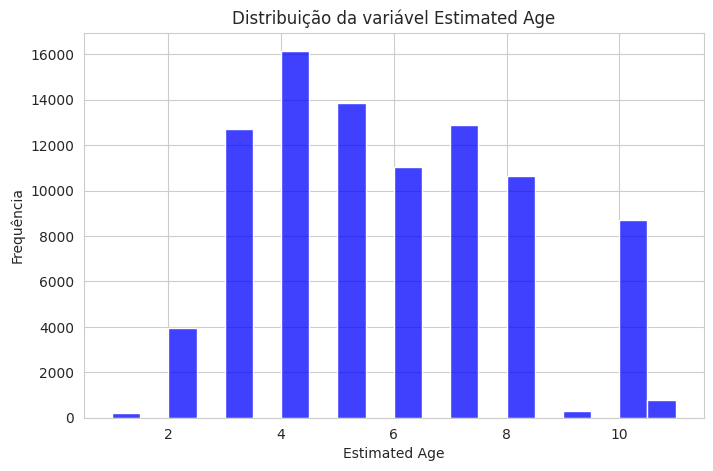

In [ ]:


# Criando uma cópia do DataFrame para evitar modificações no original
dados_copia = dados_updated.copy()

# Configuração do estilo dos gráficos
sns.set_style("whitegrid")

#===========================================================================
# Análise da Distribuição da Variavel Sex
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise da Distribuição das Variável Catgórica Sex:\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a frequência das variável Sex para identificar padrões e possíveis tendências nos dados.")

# Gráfico de frequência para variáveis categóricas
categorical_cols = ['Sex']

for col in categorical_cols:
    print(dados_copia[col].value_counts())

    plt.figure(figsize=(8, 5))
    sns.countplot(x=dados_copia[col], palette="viridis")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.title(f"Distribuição da variável {col}")
    plt.xticks(rotation=45)
    plt.show()

#===========================================================================
# Análise da Distribuição das Variável Estimated_Age
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Análise da Distribuição das Variável Estimated_Age\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a distribuição das variável Estimated_Age para entender melhor a dispersão dos valores e detectar possíveis outliers.")

# Histograma para variáveis numéricas
numerical_cols = ['Estimated Age']  # Substitua pelos nomes corretos das colunas numéricas

for col in numerical_cols:
    print(f"\n\033[1mResumo estatístico da variável: {col}\033[0m")
    print(dados_copia[col].describe())

    plt.figure(figsize=(8, 5))
    sns.histplot(dados_copia[col], bins=20, color='blue')
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.title(f"Distribuição da variável {col}")
    plt.show()



####**Análise da Distribuição do Sexo da Panthera onça**
Este gráfico apresenta a distribuição dos registos da **Panthera onça** por sexo, permitindo avaliar a representatividade de machos e fêmeas na amostragem.

**Observações Principais**:
- **Maior número de registos para machos:** Os indivíduos do sexo masculino possuem mais registos em comparação com as fêmeas.
- **Distribuição relativamente equilibrada:** Apesar da ligeira diferença, a quantidade de registos é relativamente equilibrada.

**Interpretação dos Dados**:
- O maior número de registos para machos pode indicar que os indivíduos do sexo masculino são mais monitorados, seja devido a comportamento territorial, maior área de deslocamento ou características do estudo.
- A diferença também pode estar relacionada à disponibilidade de fêmeas marcadas para rastreamento ou à taxa de mortalidade diferenciada entre os sexos.



####**Distribuição da Idade Estimada**

Este gráfico apresenta a distribuição da **idade estimada** dos indivíduos monitorados, permitindo identificar a faixa etária predominante na amostra.

**Observações Principais**:
- **Pico de registos entre 4 e 6 anos:** A maior parte dos indivíduos monitorados está nessa faixa etária.
- **Menor número de registos para idades extremas:** Poucos indivíduos são registrados com idades inferiores a 2 anos ou superiores a 10 anos.
- **Distribuição relativamente uniforme entre 3 e 8 anos:** A quantidade de registos é equilibrada nessa faixa, indicando uma boa representatividade de indivíduos adultos.

**Interpretação dos Dados**:
- A predominância de onças entre 4 e 6 anos sugere que a amostragem inclui majoritariamente indivíduos adultos, que são mais fáceis de rastrear e possuem territórios definidos.
- A baixa quantidade de indivíduos muito jovens pode estar associada à dificuldade de rastreamento de filhotes ou à mortalidade natural em estágios iniciais da vida.
- A menor presença de onças mais velhas pode indicar desafios na longevidade da espécie ou menor taxa de sobrevivência em ambientes monitorados.



###**4.3.9. Análise climática**


  - **Objetivo**: Visualizar como a temperatura e a humidade variam no dataset.

  - **Importância**: Condições climáticas podem influenciar significativamente o comportamento dos animais.

Título: Análise dos Dados Climáticos - Temperatura e Umidade
Objetivo: Examinar a distribuição da temperatura e da umidade no dataset para identificar padrões climáticos e sua possível influência no comportamento dos animais.

Resumo estatístico da temperatura e umidade:
       temperature_realistic  humidity_realistic
count          134627.000000       134627.000000
mean               27.326139           99.826741
std                 2.994380            1.148786
min                20.545861           83.057055
25%                24.820978          100.000000
50%                27.330777          100.000000
75%                29.819481          100.000000
max                34.538633          100.000000

Título: Distribuição da Temperatura
Objetivo: Visualizar a variação da temperatura no dataset para identificar tendências e extremos térmicos que possam impactar os animais.


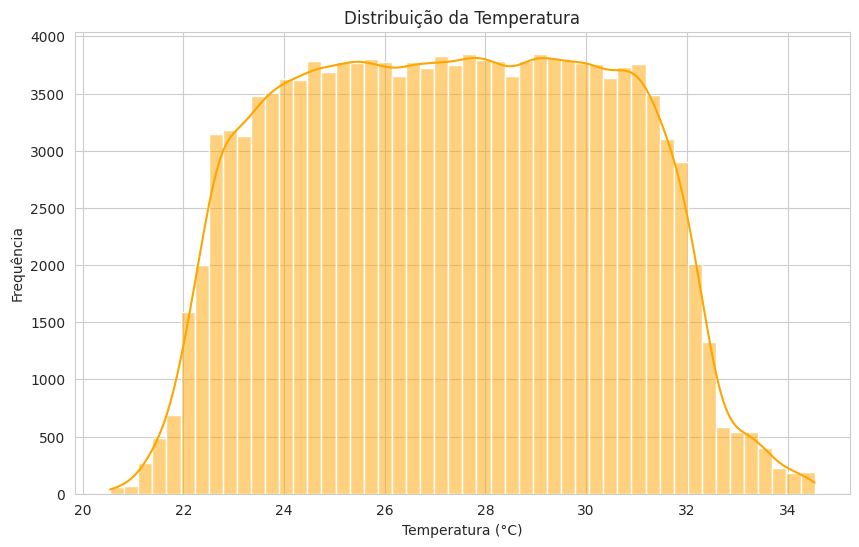


Título: Distribuição da Umidade
Objetivo: Analisar a variação da humidade no dataset para entender sua distribuição e possíveis padrões sazonais.


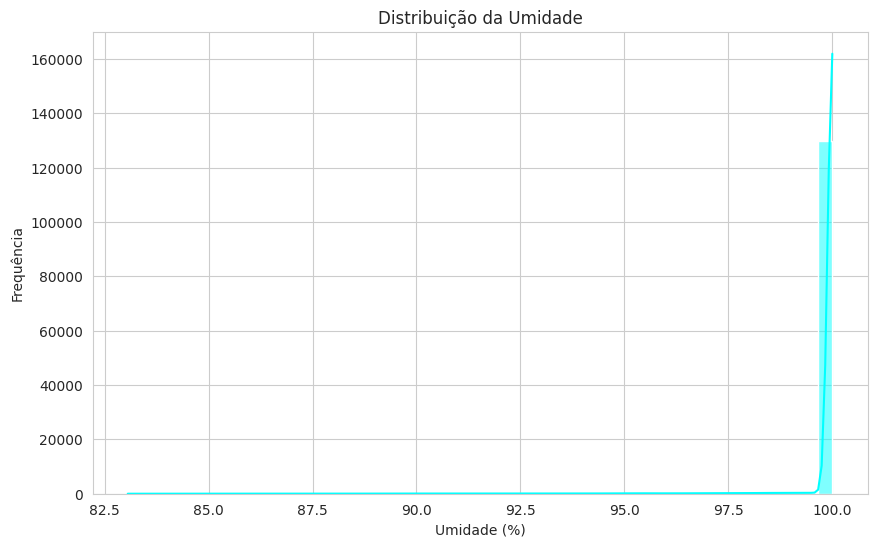

In [ ]:
#===========================================================================
# Análise dos Dados Climáticos: Temperatura e Humidade
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise dos Dados Climáticos - Temperatura e Umidade\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a distribuição da temperatura e da umidade no dataset para identificar padrões climáticos e sua possível influência no comportamento dos animais.")

# Exibir resumo estatístico da temperatura e umidade
print("\n\033[1mResumo estatístico da temperatura e umidade:\033[0m")
print(dados_updated[['temperature_realistic', 'humidity_realistic']].describe())

#===========================================================================
# Visualização da Distribuição da Temperatura
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição da Temperatura\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a variação da temperatura no dataset para identificar tendências e extremos térmicos que possam impactar os animais.")

# Gerar histograma da temperatura
plt.figure(figsize=(10, 6))
sns.histplot(dados_updated['temperature_realistic'], bins=50, kde=True, color='orange')
plt.title('Distribuição da Temperatura')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

#===========================================================================
# Visualização da Distribuição da Hmidade
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição da Umidade\033[0m")
print("\033[1mObjetivo:\033[0m Analisar a variação da humidade no dataset para entender sua distribuição e possíveis padrões sazonais.")

# Gerar histograma da umidade
plt.figure(figsize=(10, 6))
sns.histplot(dados_updated['humidity_realistic'], bins=50, kde=True, color='cyan')
plt.title('Distribuição da Umidade')
plt.xlabel('Umidade (%)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


#### **Análise da Distribuição da Temperatura e Humidade nos Registos da Panthera onça**  
Os gráficos apresentam a distribuição da **temperatura e humidade**. No entanto, é importante salientar que estes não são dados reais.  

### **Observações Principais**  
##### **Temperatura:**  
- **Faixa predominante entre 23°C e 32°C:** A maioria dos registos de temperatura encontra-se dentro deste intervalo.  
- **Pico de frequência entre 26°C e 30°C:** Indica que essa é a faixa mais comum para os registos.  
- **Distribuição relativamente simétrica:** A temperatura mantém-se dentro de um intervalo previsível, com poucos valores extremos abaixo de 22°C ou acima de 34°C.  

##### **Humidade:**  
- **Faixa predominantemente alta, entre 90% e 100%:** A maioria dos registos apresenta humidade elevada, característica de ambientes tropicais.  
- **Acumulação próxima dos 100%:** Há uma forte concentração de registos nos valores mais elevados, o que pode indicar um efeito do modelo de geração dos dados.  
- **Distribuição assimétrica:** Os valores de humidade apresentam pouca variação e estão fortemente concentrados em níveis elevados, sugerindo que o cálculo pode estar a subestimar a presença de condições mais secas.  

### **Interpretação dos Dados**  
- As condições ambientais registadas sugerem que a **Panthera onça** habita áreas quentes e húmidas, compatíveis com **florestas tropicais** e ambientes de mata densa.  
- A **faixa de temperatura relativamente estável** pode indicar que os animais são rastreados em períodos do dia com condições previsíveis ou que a recolha ocorre em regiões com poucas variações térmicas.  
- A **humidade predominantemente elevada** é coerente com habitats tropicais, mas a concentração excessiva de valores próximos de 100% sugere que o modelo de simulação pode precisar de ajustes para representar melhor variações em diferentes condições ambientais.  


###**4.3.10. Análise Ambiental**


  - **Objetivo**: Entender como as condições ambientais (elevação e proximidade da água) estão distribuídas.

  - **Importância**: Características ambientais são fundamentais para prever o comportamento e a localização dos animais.

Título: Análise dos Dados Ambientais - Elevação e Distância da Água
Objetivo: Examinar a distribuição da elevação e da distância da água no dataset para identificar padrões ambientais e sua influência no comportamento dos animais.

Resumo estatístico da elevação e distância da água:
           elevation  water_distance
count  134627.000000   134627.000000
mean      193.652437     1184.933186
std        14.212883     1147.335218
min       151.881391        0.000000
25%       200.000000     1000.000000
50%       200.000000     1000.000000
75%       200.000000     1000.000000
max       200.000000     5000.000000

Título: Distribuição da Elevação
Objetivo: Visualizar a variação da elevação no dataset para entender sua relação com a movimentação dos animais e possíveis padrões geográficos.


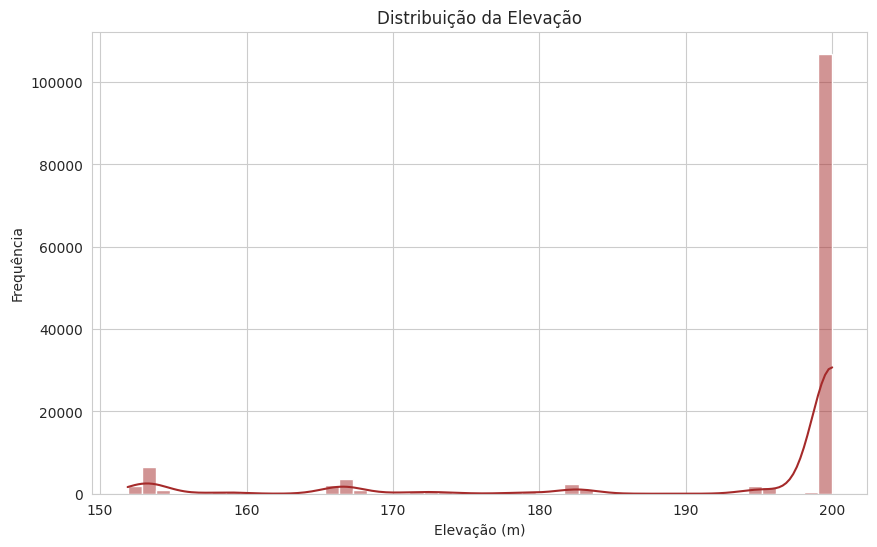


Título: Distribuição da Distância da Água
Objetivo: Analisar a variação da distância dos animais em relação à água para identificar padrões de movimentação e dependência de fontes hídricas.


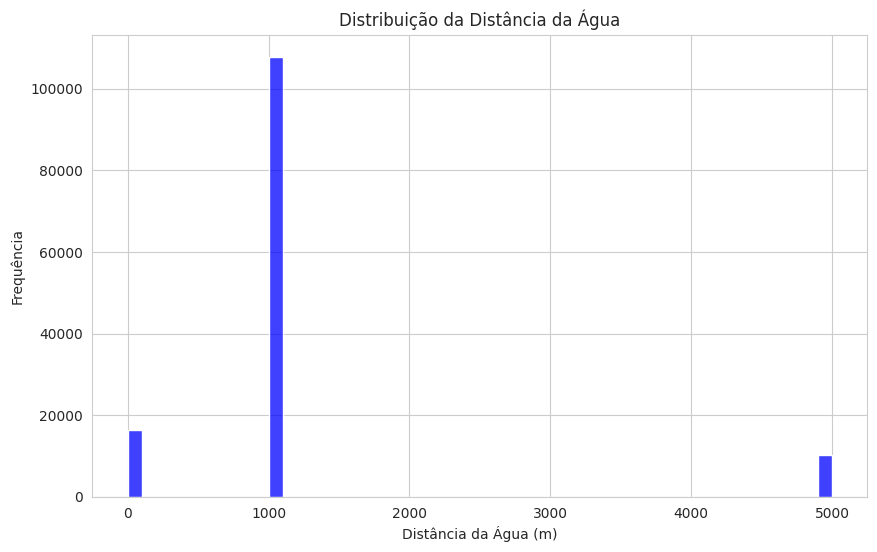

In [ ]:
#===========================================================================
# Análise dos Dados Ambientais: Elevação e Distância da Água
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise dos Dados Ambientais - Elevação e Distância da Água\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a distribuição da elevação e da distância da água no dataset para identificar padrões ambientais e sua influência no comportamento dos animais.")

# Exibir resumo estatístico da elevação e distância da água
print("\n\033[1mResumo estatístico da elevação e distância da água:\033[0m")
print(dados_updated[['elevation', 'water_distance']].describe())

#===========================================================================
# Visualização da Distribuição da Elevação
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição da Elevação\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a variação da elevação no dataset para entender sua relação com a movimentação dos animais e possíveis padrões geográficos.")

# Gerar histograma da elevação
plt.figure(figsize=(10, 6))
sns.histplot(dados_updated['elevation'], bins=50, kde=True, color='brown')
plt.title('Distribuição da Elevação')
plt.xlabel('Elevação (m)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

#===========================================================================
# Visualização da Distribuição da Distância da Água
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição da Distância da Água\033[0m")
print("\033[1mObjetivo:\033[0m Analisar a variação da distância dos animais em relação à água para identificar padrões de movimentação e dependência de fontes hídricas.")

# Gerar histograma da distância da água
plt.figure(figsize=(10, 6))
sns.histplot(dados_updated['water_distance'], bins=50, color='blue')
plt.title('Distribuição da Distância da Água')
plt.xlabel('Distância da Água (m)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


#### **Análise da Distribuição da Elevação e Distância da Água**

Estes gráficos apresentam a distribuição da **elevação e distância da água** registadas nos dados fictícios.

**Observações Principais**:
<u>Elevação: </u>
- **Maioria dos registos em torno de 200 metros:** A grande concentração de dados nessa faixa sugere que os animais estão sendo monitorados em terrenos predominantemente baixos.
- **Pequenos picos em altitudes inferiores (150m-180m):** Indica a presença de algumas onças em áreas levemente mais elevadas, mas sem grande dispersão.
- **Distribuição altamente concentrada:** A falta de uma distribuição uniforme sugere que os registos ocorreram em uma área geográfica específica, sem grande variação de altitude.

<u>Distância da Água</u>:
- **Pico significativo em torno de 1000 metros:** Indica que grande parte dos registos foi feita a essa distância de corpos d’água.
- **Menor quantidade de registos em distâncias muito curtas ou muito longas:** Embora algumas onças estejam próximas da água (<500m), há também registros isolados a mais de 4000 metros.
- **Distribuição pouco homogênea:** Sugere que algumas áreas do estudo possuem acesso limitado a fontes de água ou que a movimentação dos animais segue padrões específicos em relação à proximidade de rios e lagos.

**Interpretação dos Dados**:
- A distribuição concentrada da elevação indica que o estudo ocorre em uma região específica, predominantemente baixa, possivelmente próxima a planícies ou várzeas.
- A relação com a água pode indicar que a Panthera onça se desloca estrategicamente para manter acesso a fontes hídricas, possivelmente em função da disponibilidade de presas ou do próprio comportamento territorial.




###**4.3.11. Análise dos rotulos de comportamente**


  - **Objetivo**:Mostrar a frequência de cada categoria de movimento
  - **Importnâcia**: Entender melhor os padrões de comportamento dos jaguares."

Título: Análise da Distribuição dos Rótulos de Movimento
Objetivo: Examinar a frequência das diferentes categorias de movimento para identificar padrões comportamentais dos animais.

Distribuição dos rótulos de movimento:
movement_category
Parado        70919
A caminhar    63531
Indefinido      117
A correr         60
Name: count, dtype: int64

Título: Distribuição dos Rótulos de Movimento
Objetivo: Visualizar a frequência das diferentes categorias de movimento para entender como os animais se deslocam em diferentes contextos.


<ipython-input-43-6b1e2c4a94ed>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dados_updated['movement_category'], palette="viridis")


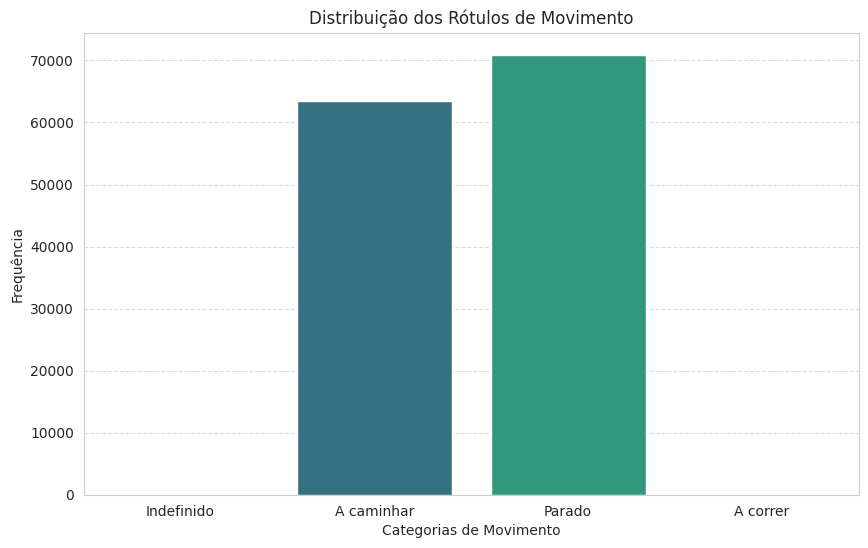

In [ ]:
#===========================================================================
# Análise da Distribuição dos Rótulos de Movimento
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise da Distribuição dos Rótulos de Movimento\033[0m")
print("\033[1mObjetivo:\033[0m Examinar a frequência das diferentes categorias de movimento para identificar padrões comportamentais dos animais.")

# Exibir distribuição dos rótulos de movimento
print("\n\033[1mDistribuição dos rótulos de movimento:\033[0m")
print(dados_updated['movement_category'].value_counts())

#===========================================================================
# Visualização da Distribuição dos Rótulos de Movimento
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Distribuição dos Rótulos de Movimento\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a frequência das diferentes categorias de movimento para entender como os animais se deslocam em diferentes contextos.")

# Gerar gráfico de barras da distribuição dos rótulos de movimento
plt.figure(figsize=(10, 6))
sns.countplot(x=dados_updated['movement_category'], palette="viridis")
plt.title("Distribuição dos Rótulos de Movimento")
plt.xlabel("Categorias de Movimento")
plt.ylabel("Frequência")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



#### **Análise do gráfico da Distribuição dos Rótulos de Movimento**
Este gráfico apresenta a distribuição das categorias de movimento da **Panthera onça**, permitindo avaliar padrões de atividade da espécie.

**Observações Principais:**
- **Dois estados predominantes:** A maioria dos registos classifica os animais como **parados** ou **a caminhar**.
- **Poucos registos para o estado "A correr":** Isso pode indicar que o comportamento de corrida é raro ou que a amostragem não captura esses momentos com frequência.
- **Categoria "Indefinido" presente, mas pouco representativa:** Pode ser resultado de limitações na classificação automática dos dados.

**Interpretação dos Dados**:
- A predominância do estado **parado** sugere que a Panthera onça passa longos períodos em repouso ou em comportamento de espera.
- O fato de haver muitos registos de **caminhada** indica deslocamentos frequentes, provavelmente relacionados a patrulhamento territorial ou busca de presas.
- A baixa presença da categoria **corrida** pode ser explicada por poucos momentos de perseguição ativa ou por limitações na taxa de amostragem do monitoramento GPS.


###**4.3.12. Análise das correlações (variavéis numéricas)**


  - **Objetivo**: Perceber como as variavéis se correlcionam
  - **Importância**:

Título: Análise da Correlação Entre Variáveis Numéricas
Objetivo: Examinar as relações entre diferentes variáveis numéricas para identificar padrões, dependências e possíveis insights sobre os fatores que influenciam o comportamento dos animais.

Título: Heatmap de Correlação Entre Variáveis Numéricas
Objetivo: Visualizar a intensidade das correlações entre variáveis para facilitar a interpretação dos relacionamentos no dataset.


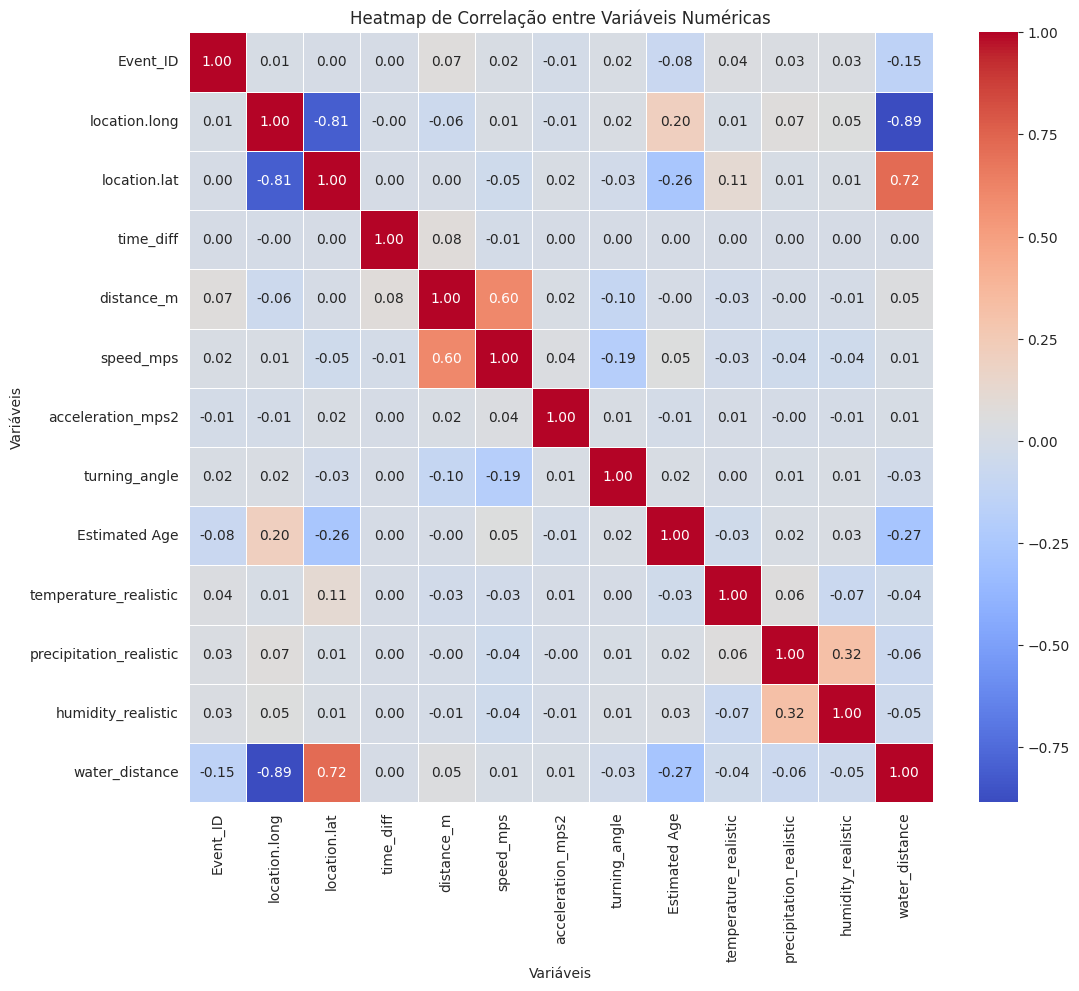

In [ ]:
#===========================================================================
# Análise da Correlação Entre Variáveis Numéricas
#===========================================================================

# Print na consola com título e objetivo
print("\033[1mTítulo: Análise da Correlação Entre Variáveis Numéricas\033[0m")
print("\033[1mObjetivo:\033[0m Examinar as relações entre diferentes variáveis numéricas para identificar padrões, dependências e possíveis insights sobre os fatores que influenciam o comportamento dos animais.")

#===========================================================================
# Seleção das Variáveis Numéricas
#===========================================================================

# Selecionar as variáveis numéricas para calcular a correlação
variaveis_numericas = dados_updated.select_dtypes(include=['float64', 'int64']).columns

# Remover colunas específicas que não devem ser incluídas na análise
colunas_para_excluir = ['individual.taxon.canonical.name', 'study.name', 'country', 'elevation']
variaveis_numericas = [col for col in variaveis_numericas if col not in colunas_para_excluir]

#===========================================================================
# Cálculo da Matriz de Correlação
#===========================================================================

# Calcular a matriz de correlação com as colunas selecionadas
correlation_matrix = dados_updated[variaveis_numericas].corr()


#===========================================================================
# Visualização da Matriz de Correlação com Heatmap
#===========================================================================

# Print na consola com título e objetivo
print("\n\033[1mTítulo: Heatmap de Correlação Entre Variáveis Numéricas\033[0m")
print("\033[1mObjetivo:\033[0m Visualizar a intensidade das correlações entre variáveis para facilitar a interpretação dos relacionamentos no dataset.")

# Gerar heatmap da matriz de correlação
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title('Heatmap de Correlação entre Variáveis Numéricas')
plt.xlabel('Variáveis')
plt.ylabel('Variáveis')
plt.show()


#### **Análise do Heatmap de Correlação entre Variáveis Numéricas**

Este gráfico apresenta a **matriz de correlação** entre variáveis numéricas dos registos da **Panthera onça**, permitindo identificar relações entre diferentes fatores ambientais e comportamentais.

**Observações Principais**:
- **Correlação negativa forte entre longitude e latitude (-0.81):** Sugere que os dados foram coletados em uma região específica com relação geográfica inversa.
- **Correlação positiva entre distância percorrida e velocidade (0.60):** Indica que deslocamentos maiores estão associados a velocidades mais altas, o que é esperado.

**Interpretação dos Dados**:
- A relação entre velocidade e distância percorrida é intuitiva e confirma padrões esperados de movimentação animal.
- A correlação forte entre variáveis geográficas e distância da água sugere que a localização influencia diretamente o acesso a recursos hídricos (Importante realça que os dados climáticos e de terreno são fictícios) .
- A relação entre idade e umidade pode estar associada a mudanças de habitat ao longo do ciclo de vida dos indivíduos (Importante realça que os dados climáticos e de terreno são fictícios).


#**5. Preparar o Modelo** (Novo DATASET: dados_updated)

## 5.1. <u> Selcionar as features relevantes

In [ ]:
# Selecionar as Features
selected_features = [
    'individual.local.identifier (ID)',
    'Estimated Age', 'Sex', 'day', 'month', 'year', 'hour', 'minute', 'season', 'time_period',
    'location.lat', 'location.long', 'distance_m', 'acceleration_mps2', 'turning_angle',
    'temperature_realistic', 'humidity_realistic', 'precipitation_realistic',
    'vegetation_type', 'elevation', 'water_distance', 'movement_category'
]



## 5.2<u> Verificar os valores ausentes e remover os de menor valor

In [ ]:
# Criar cópia dos dados filtrados
dados_filtrados = dados_updated[selected_features].copy()
dados_filtrados = dados_updated.groupby('individual.local.identifier (ID)').apply(lambda x: x.iloc[2:]).reset_index(drop=True)

# Verificar valores ausentes antes da limpeza
print("\n🔹 Verificação de valores ausentes antes do pré-processamento:")
print(dados_filtrados.isnull().sum())

# Remover linhas onde 'turning_angle' é NaN
dados_filtrados.dropna(subset=['turning_angle'], inplace=True)
dados_filtrados.shape


🔹 Verificação de valores ausentes antes do pré-processamento:
Event_ID                                0
timestamp                               0
location.long                           0
location.lat                            0
individual.taxon.canonical.name         0
tag.local.identifier                    0
individual.local.identifier (ID)        0
study.name                              0
country                                 0
day                                     0
month                                   0
year                                    0
hour                                    0
minute                                  0
time_diff                               0
distance_m                              0
speed_mps                               0
acceleration_mps2                       0
turning_angle                         429
time_period                             0
Sex                                 43298
Estimated Age                       43314
season       

<ipython-input-46-8c912fa5037e>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dados_filtrados = dados_updated.groupby('individual.local.identifier (ID)').apply(lambda x: x.iloc[2:]).reset_index(drop=True)


(133964, 30)

## 5.3 <u> Separar Features (X) e Target (y)

In [ ]:
# Criar colunas para localização futura dentro de cada ID (sem misturar trajetórias)
dados_filtrados["location.lat_futuro"] = dados_filtrados.groupby("individual.local.identifier (ID)")["location.lat"].shift(-1)
dados_filtrados["location.long_futuro"] = dados_filtrados.groupby("individual.local.identifier (ID)")["location.long"].shift(-1)

# Remover linhas onde não há valores futuros (última posição de cada onça)
dados_filtrados = dados_filtrados.dropna()

# 1. Separar Features para Cada Target (removendo as colunas-alvo)
features_movimento = dados_filtrados.drop(columns=['individual.local.identifier (ID)','movement_category', 'location.lat', 'location.long', 'location.lat_futuro', 'location.long_futuro']).columns.tolist()
features_localizacao = dados_filtrados.drop(columns=['individual.local.identifier (ID)', 'location.lat_futuro', 'location.long_futuro']).columns.tolist()

# Criar datasets separados para cada previsão
X_movimento = dados_filtrados[features_movimento]  # Features para prever movimento
X_localizacao = dados_filtrados[features_localizacao]  # Features para prever localização

# Targets (mantidos os mesmos)
y_class = dados_filtrados['movement_category']  # Target para classificação (movimento)
y_lat = dados_filtrados['location.lat_futuro']  # Target correto para prever latitude FUTURA
y_long = dados_filtrados['location.long_futuro']  # Target correto para prever longitude FUTURA


##5.4 <u> Definir Variáveis Numéricas e Categóricas

In [ ]:
#1. Definir variáveis numéricas para cada previsão
numerical_features_movimento = [
    'Estimated Age', 'day', 'month', 'year', 'hour', 'minute',
    'distance_m', 'acceleration_mps2', 'turning_angle',
    'temperature_realistic', 'humidity_realistic', 'precipitation_realistic',
    'elevation', 'water_distance'
]

numerical_features_localizacao = [
    'Estimated Age', 'day', 'month', 'year', 'hour', 'minute',
    'distance_m', 'speed_mps', 'acceleration_mps2', 'turning_angle',
    'temperature_realistic', 'humidity_realistic', 'precipitation_realistic',
    'elevation', 'water_distance'
]

# 2. Definir variáveis categóricas para cada previsão
if any(col.startswith('season_') for col in dados_updated.columns):
    categorical_features_movimento = [col for col in dados_filtrados.columns if col.startswith(('season_', 'time_period_', 'vegetation_type_', 'Sex_'))]
    categorical_features_localizacao = categorical_features_movimento + [col for col in dados_filtrados.columns if col.startswith('movement_category_')]
else:
    categorical_features_movimento = ['season', 'time_period', 'vegetation_type', 'Sex']
    categorical_features_localizacao = categorical_features_movimento + ['movement_category']


##5.5 <u>  Criar Pipelines de Transformação

In [ ]:
# Transformação para variáveis numéricas (preenchimento e normalização)
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

#  Transformação para variáveis categóricas (preenchimento e One-Hot Encoding)
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop='first', handle_unknown="ignore"))
])


## 5.6 <u> Criar e Aplicar o Pipeline de Pré-Processamento

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 🔹 Criar pré-processador para MOVIMENTO
preprocessor_movimento = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features_movimento),
    ("cat", categorical_transformer, categorical_features_movimento)
])

# 🔹 Criar pré-processador para LOCALIZAÇÃO
preprocessor_localizacao = ColumnTransformer(transformers=[
    ("num", numerical_transformer, numerical_features_localizacao),
    ("cat", categorical_transformer, categorical_features_localizacao)
])

# 🔹 Criar Pipelines de Pré-Processamento para cada previsão
pipeline_movimento = Pipeline(steps=[("preprocessor", preprocessor_movimento)])
pipeline_localizacao = Pipeline(steps=[("preprocessor", preprocessor_localizacao)])

# 🔹 Aplicar a pipeline separadamente para cada conjunto de features
X_transformed_movimento = pipeline_movimento.fit_transform(X_movimento)
X_transformed_localizacao = pipeline_localizacao.fit_transform(X_localizacao)


## 5.7 <u> Aplicar Label Encoding no Target

In [ ]:
# Aplicar Label Encoding no target (movement_category)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_class)


## 5.8 <u> Converter X Transformado para DataFrame

In [ ]:

# Obter nomes das colunas categóricas transformadas para MOVIMENTO
categorical_encoded_columns_mov = pipeline_movimento.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features_movimento)

# Obter nomes das colunas categóricas transformadas para LOCALIZAÇÃO
categorical_encoded_columns_loc = pipeline_localizacao.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features_localizacao)

# Criar DataFrame com as colunas transformadas para MOVIMENTO
all_columns_movimento = numerical_features_movimento + list(categorical_encoded_columns_mov)
X_transformed_movimento_df = pd.DataFrame(X_transformed_movimento, columns=all_columns_movimento)

# Criar DataFrame com as colunas transformadas para LOCALIZAÇÃO
all_columns_localizacao = numerical_features_localizacao + list(categorical_encoded_columns_loc)
X_transformed_localizacao_df = pd.DataFrame(X_transformed_localizacao, columns=all_columns_localizacao)

# Mostrar o resultado final
print("\n🔹 Mapeamento do Label Encoding para 'movement_category':")
label_mapping = dict(enumerate(label_encoder.classes_))
for code, category in label_mapping.items():
    print(f"{code} → {category}")

# Exibir amostra dos datasets transformados
print("\n🔹 Amostra do dataset final após pré-processamento (Movimento):")
print(tabulate(X_transformed_movimento_df.head(), headers='keys', tablefmt='grid'))
print(X_transformed_movimento_df.shape)

print("\n🔹 Amostra do dataset final após pré-processamento (Localização):")
print(tabulate(X_transformed_localizacao_df.head(), headers='keys', tablefmt='grid'))
print(X_transformed_localizacao_df.shape)



🔹 Mapeamento do Label Encoding para 'movement_category':
0 → A caminhar
1 → A correr
2 → Parado

🔹 Amostra do dataset final após pré-processamento (Movimento):
+----+-----------------+-----------+----------+---------+-----------+-------------+--------------+---------------------+-----------------+-------------------------+----------------------+---------------------------+-------------+------------------+-----------------+--------------------+----------------+---------------------+---------------------+---------------------+----------------------------+------------+
|    |   Estimated Age |       day |    month |    year |      hour |      minute |   distance_m |   acceleration_mps2 |   turning_angle |   temperature_realistic |   humidity_realistic |   precipitation_realistic |   elevation |   water_distance |   season_outono |   season_primavera |   season_verão |   time_period_Manhã |   time_period_Noite |   time_period_Tarde |   vegetation_type_floresta |   Sex_Male |
+====+=======

## 5.9 <u>  Configurar TimeSeriesSplit

In [ ]:
# Configurar Time Series Split
tscv = TimeSeriesSplit(n_splits=5)


##5.10 <u> Dividir o Dataset em Treino e Teste

In [ ]:
#  Criar divisões de treino e teste (garantindo consistência nos índices)
splits = list(tscv.split(X_transformed_movimento_df))  # Aplicamos o TimeSeriesSplit apenas uma vez

#  Usar o último split como conjunto final de treino e teste
train_index, test_index = splits[-1]

#  Separar treino e teste para MOVIMENTO (Classificação)
X_train_mov, X_test_mov = X_transformed_movimento_df.iloc[train_index], X_transformed_movimento_df.iloc[test_index]
y_train_class, y_test_class = y_encoded[train_index], y_encoded[test_index]

# separar treino e teste para LOCALIZAÇÃO (Regressão)
X_train_loc, X_test_loc = X_transformed_localizacao_df.iloc[train_index], X_transformed_localizacao_df.iloc[test_index]
y_train_lat, y_test_lat = y_lat.iloc[train_index], y_lat.iloc[test_index]
y_train_long, y_test_long = y_long.iloc[train_index], y_long.iloc[test_index]

#  Exibir Resumo da Divisão dos Dados
print("\n📊 === Resumo da Divisão dos Dados ===\n")
for i, (train_index, test_index) in enumerate(splits, start=1):
    print(f"🔹 Split {i}:")
    print(f"  🔹 Tamanho do treino: {len(train_index)}, Índices {train_index[0]} - {train_index[-1]}")
    print(f"  🔹 Tamanho do teste: {len(test_index)}, Índices {test_index[0]} - {test_index[-1]}")
    print("-" * 50)



📊 === Resumo da Divisão dos Dados ===

🔹 Split 1:
  🔹 Tamanho do treino: 15118, Índices 0 - 15117
  🔹 Tamanho do teste: 15114, Índices 15118 - 30231
--------------------------------------------------
🔹 Split 2:
  🔹 Tamanho do treino: 30232, Índices 0 - 30231
  🔹 Tamanho do teste: 15114, Índices 30232 - 45345
--------------------------------------------------
🔹 Split 3:
  🔹 Tamanho do treino: 45346, Índices 0 - 45345
  🔹 Tamanho do teste: 15114, Índices 45346 - 60459
--------------------------------------------------
🔹 Split 4:
  🔹 Tamanho do treino: 60460, Índices 0 - 60459
  🔹 Tamanho do teste: 15114, Índices 60460 - 75573
--------------------------------------------------
🔹 Split 5:
  🔹 Tamanho do treino: 75574, Índices 0 - 75573
  🔹 Tamanho do teste: 15114, Índices 75574 - 90687
--------------------------------------------------


#6. **Modelação**

## <u> 6.1 Ajuste de Hiperparametros

In [ ]:
"""

# Configurar Modelos Base
models = {
    "RandomForestClassifier": RandomForestClassifier(),
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBClassifier": XGBClassifier(eval_metric='mlogloss'),
    "XGBRegressor": XGBRegressor(objective='reg:squarederror')
}

#  Definir Hiperparâmetros para Busca
param_grid = {
    "RandomForestClassifier": {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    "RandomForestRegressor": {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    },
    "XGBClassifier": {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.7, 0.8, 0.9]
    },
    "XGBRegressor": {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.7, 0.8, 0.9]
    }
}

#  Ajuste de Hiperparâmetros
def find_best_hyperparameters(model_name, X, y, preprocessor):

    model = models[model_name]
    pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

    # Definir métrica de avaliação correta
    scoring_metric = 'accuracy' if "Classifier" in model_name else 'neg_mean_squared_error'

    search = GridSearchCV(
        pipeline,
        param_grid[model_name],
        cv=tscv,
        scoring=scoring_metric,
        verbose=2,
        n_jobs=-1  # Usa múltiplos núcleos para acelerar
    )

    search.fit(X, y)

    print(f"\n Melhor hiperparâmetro para {model_name}: {search.best_params_}")
    return search.best_params_

#  Identificar os Melhores Hiperparâmetros (Corre apenas uma vez)
best_params_rf_classifier = find_best_hyperparameters("RandomForestClassifier", X_transformed_movimento_df, y_class, preprocessor_movimento)
best_params_xgb_classifier = find_best_hyperparameters("XGBClassifier", X_transformed_movimento_df, y_class, preprocessor_movimento)
best_params_rf_regressor = find_best_hyperparameters("RandomForestRegressor", X_transformed_localizacao_df, y_lat, preprocessor_localizacao)
best_params_xgb_regressor = find_best_hyperparameters("XGBRegressor", X_transformed_localizacao_df, y_lat, preprocessor_localizacao)
"""

'\n\n# Configurar Modelos Base\nmodels = {\n    "RandomForestClassifier": RandomForestClassifier(),\n    "RandomForestRegressor": RandomForestRegressor(),\n    "XGBClassifier": XGBClassifier(eval_metric=\'mlogloss\'),\n    "XGBRegressor": XGBRegressor(objective=\'reg:squarederror\')\n}\n\n#  Definir Hiperparâmetros para Busca\nparam_grid = {\n    "RandomForestClassifier": {\n        \'model__n_estimators\': [100, 200, 300],\n        \'model__max_depth\': [None, 10, 20],\n        \'model__min_samples_split\': [2, 5, 10],\n        \'model__min_samples_leaf\': [1, 2, 4]\n    },\n    "RandomForestRegressor": {\n        \'model__n_estimators\': [100, 200, 300],\n        \'model__max_depth\': [None, 10, 20],\n        \'model__min_samples_split\': [2, 5, 10],\n        \'model__min_samples_leaf\': [1, 2, 4]\n    },\n    "XGBClassifier": {\n        \'model__n_estimators\': [100, 200, 300],\n        \'model__max_depth\': [3, 5, 7],\n        \'model__learning_rate\': [0.01, 0.1, 0.2],\n        \'

## 6.2 <u> Função para treinar os modelos

In [ ]:
# Manter trained_models entre execuções (evita reset a cada run)
if 'trained_models' not in globals():
    trained_models = {}

# Criar Função para Treinar Modelos, incluindo o Ensemble
def train_model(model_name, model, X_train, y_train):
    """
    Treina um modelo e retorna o modelo treinado.

    Parâmetros:
        model_name (str): Nome do modelo (para referência).
        model (objeto): Modelo a ser treinado.
        X_train (DataFrame y): Features de treino (já preprocessadas).
        y_train (Series ou array): Target de treino.

    Retorna:
        Modelo treinado.
    """
    print(f"\n=== Treinando {model_name} ===")

    # Medir tempo de treino
    start_time = time.time()

    # Se o modelo for VotingClassifier, garantir que os modelos base já estão treinados
    if isinstance(model, VotingClassifier):
        print("🔹 Configurando ensemble com modelos base treinados...")
        model = VotingClassifier(estimators=[
            ('rf', trained_models['RandomForestClassifier']),
            ('xgb', trained_models['XGBClassifier'])
        ], voting='soft')

    # Treinar o modelo
    model.fit(X_train, y_train)

    # Tempo decorrido
    elapsed_time = time.time() - start_time

    # Salvar o modelo treinado no dicionário
    trained_models[model_name] = model
    print(f"✅ {model_name} treinado com sucesso em {elapsed_time:.2f} segundos!")

    return model


### 6.2.1 Treinar os modelos de classificação

In [ ]:
# Verificar se os dados já estão transformados corretamente (evita erro)
print(f"🔹 Shape de X_train_mov: {X_train_mov.shape}")

#  Remover e treinar RandomForestClassifier
if 'RandomForestClassifier' in trained_models:
    print("\n🔄 Removendo modelo antigo: RandomForestClassifier")
    del trained_models['RandomForestClassifier']

trained_models['RandomForestClassifier'] = train_model(
    "RandomForestClassifier", RandomForestClassifier(random_state=42, n_jobs=-1), X_train_mov, y_train_class
)

#  Remover e treinar XGBClassifier
if 'XGBClassifier' in trained_models:
    print("\n🔄 Removendo modelo antigo: XGBClassifier")
    del trained_models['XGBClassifier']

trained_models['XGBClassifier'] = train_model(
    "XGBClassifier", XGBClassifier(random_state=42, eval_metric='mlogloss', n_jobs=-1), X_train_mov, y_train_class
)

#  Criar e treinar Ensemble (Voting Classifier) **após os modelos base estarem treinados**
if 'VotingClassifier' in trained_models:
    print("\n🔄 Removendo modelo antigo: VotingClassifier")
    del trained_models['VotingClassifier']

print("\n🔹 Criando e treinando VotingClassifier...")
trained_models['VotingClassifier'] = train_model(
    "VotingClassifier",
    VotingClassifier(estimators=[
        ('rf', trained_models['RandomForestClassifier']),
        ('xgb', trained_models['XGBClassifier'])
    ], voting='soft'),
    X_train_mov, y_train_class  # Usamos os dados corretos!
)

#  Verificar se os modelos foram armazenados corretamente
print("\n🔹 Modelos treinados disponíveis em trained_models:")
print(trained_models.keys())


🔹 Shape de X_train_mov: (75574, 22)

=== Treinando RandomForestClassifier ===
✅ RandomForestClassifier treinado com sucesso em 12.64 segundos!

=== Treinando XGBClassifier ===
✅ XGBClassifier treinado com sucesso em 5.00 segundos!

🔹 Criando e treinando VotingClassifier...

=== Treinando VotingClassifier ===
🔹 Configurando ensemble com modelos base treinados...
✅ VotingClassifier treinado com sucesso em 16.52 segundos!

🔹 Modelos treinados disponíveis em trained_models:
dict_keys(['RandomForestClassifier', 'XGBClassifier', 'VotingClassifier'])


### 6.2.2 Treinar os modelos de regressão

In [ ]:
# Garantir que trained_models existe
if 'trained_models' not in globals():
    trained_models = {}

#  Treinar os Modelos de Regressão (Latitude e Longitude)

# RandomForestRegressor - Latitude
if 'RandomForestRegressor_Lat' in trained_models:
    print("\n🔄 Removendo modelo antigo: RandomForestRegressor_Lat")
    del trained_models['RandomForestRegressor_Lat']

trained_models['RandomForestRegressor_Lat'] = train_model(
    "RandomForestRegressor_Lat", RandomForestRegressor(random_state=42, n_jobs=-1), X_train_loc, y_train_lat
)

# RandomForestRegressor - Longitude
if 'RandomForestRegressor_Long' in trained_models:
    print("\n🔄 Removendo modelo antigo: RandomForestRegressor_Long")
    del trained_models['RandomForestRegressor_Long']

trained_models['RandomForestRegressor_Long'] = train_model(
    "RandomForestRegressor_Long", RandomForestRegressor(random_state=42, n_jobs=-1), X_train_loc, y_train_long
)

# XGBRegressor - Latitude
if 'XGBRegressor_Lat' in trained_models:
    print("\n🔄 Removendo modelo antigo: XGBRegressor_Lat")
    del trained_models['XGBRegressor_Lat']

trained_models['XGBRegressor_Lat'] = train_model(
    "XGBRegressor_Lat", XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1), X_train_loc, y_train_lat
)

# XGBRegressor - Longitude
if 'XGBRegressor_Long' in trained_models:
    print("\n🔄 Removendo modelo antigo: XGBRegressor_Long")
    del trained_models['XGBRegressor_Long']

trained_models['XGBRegressor_Long'] = train_model(
    "XGBRegressor_Long", XGBRegressor(random_state=42, objective='reg:squarederror', n_jobs=-1), X_train_loc, y_train_long
)

# Criar as Features para o Meta-Modelo (Ensemble)
print("\n🔹 Criando features para Meta-Modelo...")

# Previsões para Latitude
train_pred_rf_lat = trained_models['RandomForestRegressor_Lat'].predict(X_train_loc).reshape(-1, 1)
train_pred_xgb_lat = trained_models['XGBRegressor_Lat'].predict(X_train_loc).reshape(-1, 1)
test_pred_rf_lat = trained_models['RandomForestRegressor_Lat'].predict(X_test_loc).reshape(-1, 1)
test_pred_xgb_lat = trained_models['XGBRegressor_Lat'].predict(X_test_loc).reshape(-1, 1)

# Previsões para Longitude
train_pred_rf_long = trained_models['RandomForestRegressor_Long'].predict(X_train_loc).reshape(-1, 1)
train_pred_xgb_long = trained_models['XGBRegressor_Long'].predict(X_train_loc).reshape(-1, 1)
test_pred_rf_long = trained_models['RandomForestRegressor_Long'].predict(X_test_loc).reshape(-1, 1)
test_pred_xgb_long = trained_models['XGBRegressor_Long'].predict(X_test_loc).reshape(-1, 1)

# Criar datasets para o Meta-Modelo
X_meta_train_lat = np.hstack((train_pred_rf_lat, train_pred_xgb_lat))
X_meta_test_lat = np.hstack((test_pred_rf_lat, test_pred_xgb_lat))
X_meta_train_long = np.hstack((train_pred_rf_long, train_pred_xgb_long))
X_meta_test_long = np.hstack((test_pred_rf_long, test_pred_xgb_long))

# Treinar o Meta-Modelo (Ensemble para Regressão)

# Meta-Modelo - Latitude
if 'MetaModel_Lat' in trained_models:
    print("\n🔄 Removendo modelo antigo: MetaModel_Lat")
    del trained_models['MetaModel_Lat']

trained_models['MetaModel_Lat'] = train_model(
    "MetaModel_Lat", LinearRegression(), X_meta_train_lat, y_train_lat
)

# Meta-Modelo - Longitude
if 'MetaModel_Long' in trained_models:
    print("\n🔄 Removendo modelo antigo: MetaModel_Long")
    del trained_models['MetaModel_Long']

trained_models['MetaModel_Long'] = train_model(
    "MetaModel_Long", LinearRegression(), X_meta_train_long, y_train_long
)

# Verificar se os modelos foram armazenados corretamente
print("\n🔹 Modelos treinados disponíveis em trained_models:")
print(trained_models.keys())


=== Treinando RandomForestRegressor_Lat ===
✅ RandomForestRegressor_Lat treinado com sucesso em 106.63 segundos!

=== Treinando RandomForestRegressor_Long ===
✅ RandomForestRegressor_Long treinado com sucesso em 113.53 segundos!

=== Treinando XGBRegressor_Lat ===
✅ XGBRegressor_Lat treinado com sucesso em 0.95 segundos!

=== Treinando XGBRegressor_Long ===
✅ XGBRegressor_Long treinado com sucesso em 0.97 segundos!

🔹 Criando features para Meta-Modelo...

=== Treinando MetaModel_Lat ===
✅ MetaModel_Lat treinado com sucesso em 0.02 segundos!

=== Treinando MetaModel_Long ===
✅ MetaModel_Long treinado com sucesso em 0.01 segundos!

🔹 Modelos treinados disponíveis em trained_models:
dict_keys(['RandomForestClassifier', 'XGBClassifier', 'VotingClassifier', 'RandomForestRegressor_Lat', 'RandomForestRegressor_Long', 'XGBRegressor_Lat', 'XGBRegressor_Long', 'MetaModel_Lat', 'MetaModel_Long'])


##6.3 Função para Avaliar os modelos em treino e teste

## 6.3.1 Avaliar os modelos de classificação

In [ ]:
# Função para avaliar modelos de Classificação com formatação correta
def evaluate_classification_models(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n=== Avaliação do {model_name} ===")

    # Fazer previsões no Treino e no Teste
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Cálculo da Acurácia
    accuracy_train = accuracy_score(y_train, y_train_pred)
    accuracy_test = accuracy_score(y_test, y_test_pred)

    print(f"🔹 Acurácia (Treino): {accuracy_train:.4f}")
    print(f"🔹 Acurácia (Teste): {accuracy_test:.4f}")

    # Matriz de Confusão para Treino e Teste
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Criar uma figura com subplots (Matriz Treino à esquerda, Matriz Teste à direita)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Matriz de Confusão (Treino) - Melhor Ajustada
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", linewidths=0.5, square=True, ax=ax[0])
    ax[0].set_title(f"{model_name} - Matriz de Confusão (Treino)")
    ax[0].set_xlabel("Predito")
    ax[0].set_ylabel("Real")

    # Matriz de Confusão (Teste) - Melhor Ajustada
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", linewidths=0.5, square=True, ax=ax[1])
    ax[1].set_title(f"{model_name} - Matriz de Confusão (Teste)")
    ax[1].set_xlabel("Predito")
    ax[1].set_ylabel("Real")

    plt.tight_layout()
    plt.show()

    # Relatório de Classificação (Treino) com Tabulate
    report_train = classification_report(y_train, y_train_pred, output_dict=True)
    df_report_train = pd.DataFrame(report_train).transpose()
    df_report_train = df_report_train.round(4)  # Definir 4 casas decimais
    print(f"\n🔹 {model_name} - Relatório de Classificação (Treino):")
    print(tabulate(df_report_train, headers="keys", tablefmt="grid", floatfmt=".4f"))

    # Relatório de Classificação (Teste) com Tabulate
    report_test = classification_report(y_test, y_test_pred, output_dict=True)
    df_report_test = pd.DataFrame(report_test).transpose()
    df_report_test = df_report_test.round(4)  # Definir 4 casas decimais
    print(f"\n🔹 {model_name} - Relatório de Classificação (Teste):")
    print(tabulate(df_report_test, headers="keys", tablefmt="grid", floatfmt=".4f"))

    return accuracy_train, accuracy_test



📊 Avaliação dos Modelos de Classificação

=== Avaliação do RandomForestClassifier ===
🔹 Acurácia (Treino): 1.0000
🔹 Acurácia (Teste): 0.9277


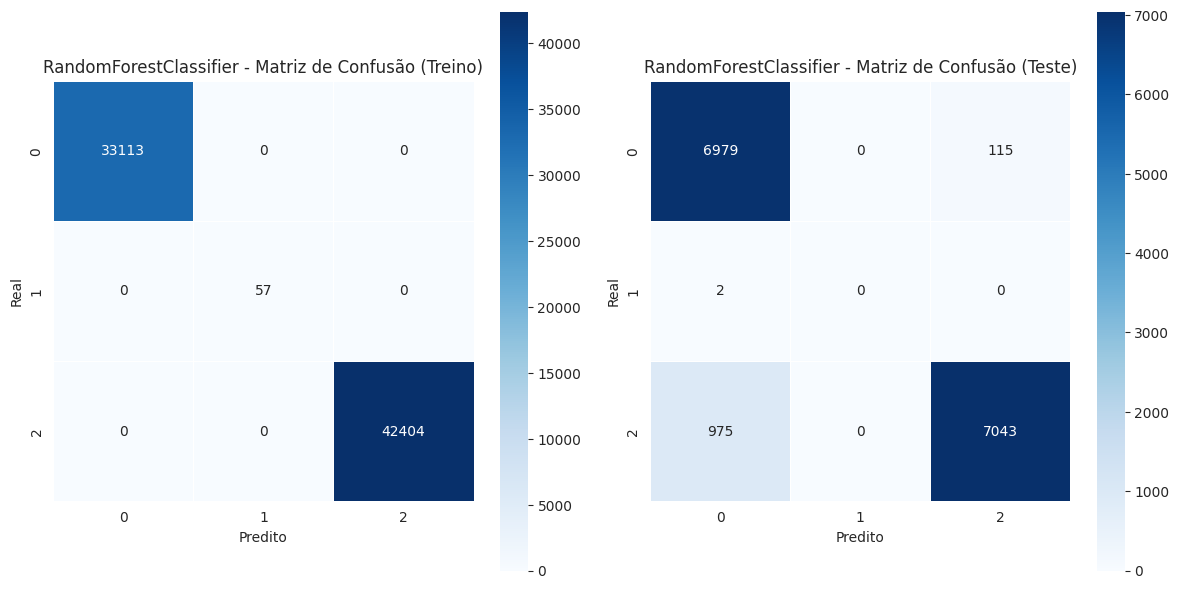


🔹 RandomForestClassifier - Relatório de Classificação (Treino):
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
+==============+=============+==========+============+============+
| 0            |      1.0000 |   1.0000 |     1.0000 | 33113.0000 |
+--------------+-------------+----------+------------+------------+
| 1            |      1.0000 |   1.0000 |     1.0000 |    57.0000 |
+--------------+-------------+----------+------------+------------+
| 2            |      1.0000 |   1.0000 |     1.0000 | 42404.0000 |
+--------------+-------------+----------+------------+------------+
| accuracy     |      1.0000 |   1.0000 |     1.0000 |     1.0000 |
+--------------+-------------+----------+------------+------------+
| macro avg    |      1.0000 |   1.0000 |     1.0000 | 75574.0000 |
+--------------+-------------+----------+------------+------------+
| weighted avg |      1.0000 |   1.0000 |     1.000

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 Acurácia (Treino): 0.9929
🔹 Acurácia (Teste): 0.9288


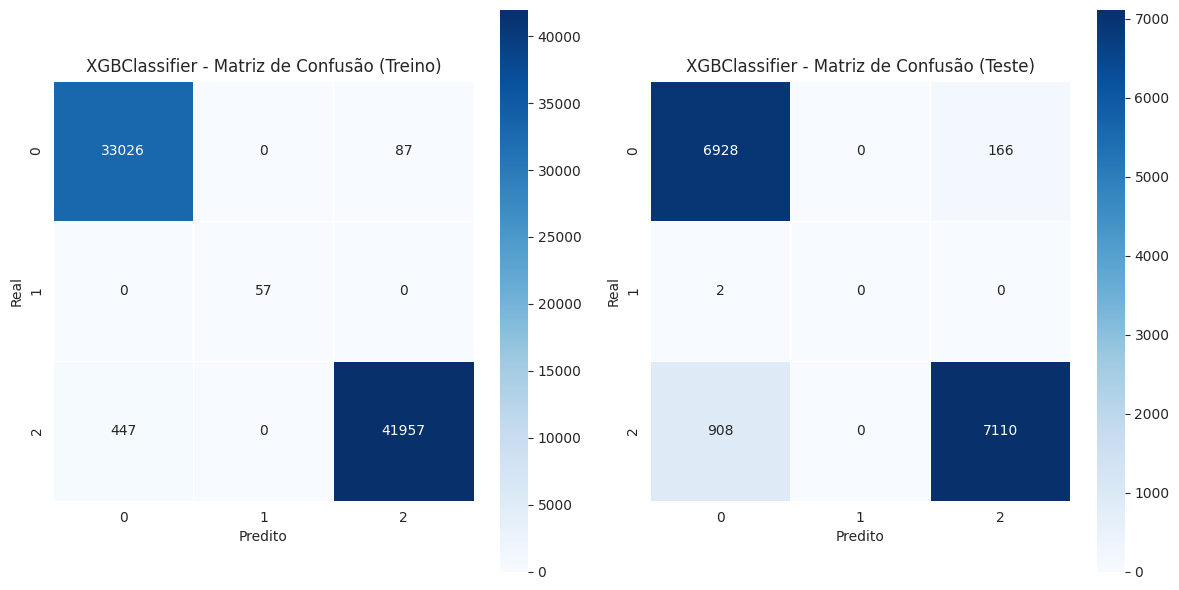


🔹 XGBClassifier - Relatório de Classificação (Treino):
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
+==============+=============+==========+============+============+
| 0            |      0.9866 |   0.9974 |     0.9920 | 33113.0000 |
+--------------+-------------+----------+------------+------------+
| 1            |      1.0000 |   1.0000 |     1.0000 |    57.0000 |
+--------------+-------------+----------+------------+------------+
| 2            |      0.9979 |   0.9895 |     0.9937 | 42404.0000 |
+--------------+-------------+----------+------------+------------+
| accuracy     |      0.9929 |   0.9929 |     0.9929 |     0.9929 |
+--------------+-------------+----------+------------+------------+
| macro avg    |      0.9949 |   0.9956 |     0.9952 | 75574.0000 |
+--------------+-------------+----------+------------+------------+
| weighted avg |      0.9930 |   0.9929 |     0.9929 | 75574

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


🔹 Acurácia (Treino): 0.9976
🔹 Acurácia (Teste): 0.9291


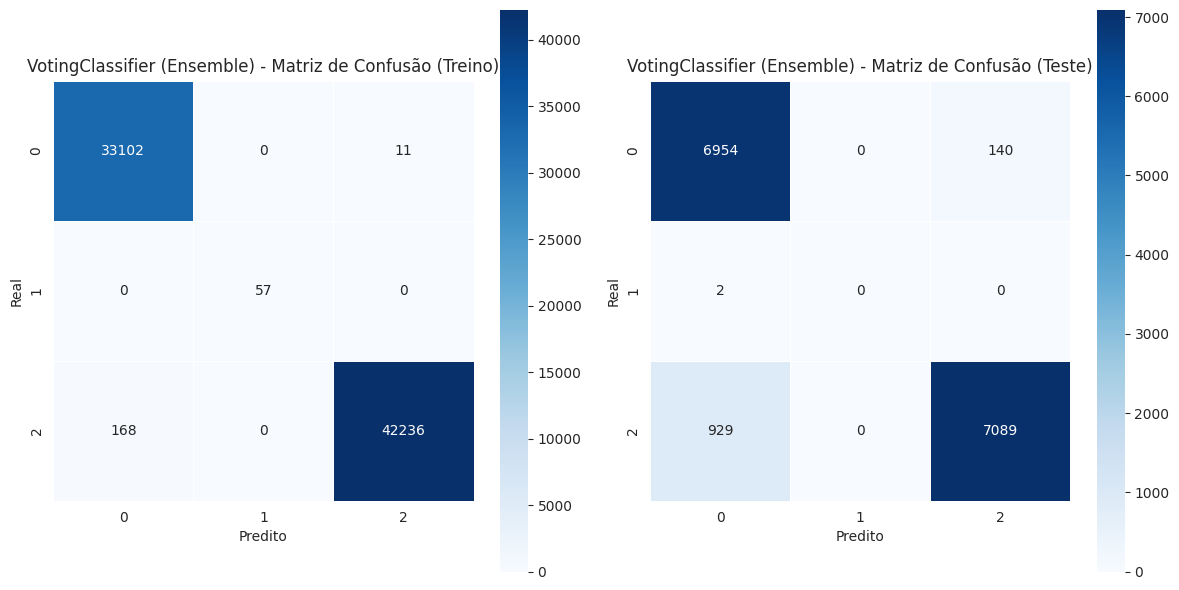


🔹 VotingClassifier (Ensemble) - Relatório de Classificação (Treino):
+--------------+-------------+----------+------------+------------+
|              |   precision |   recall |   f1-score |    support |
+==============+=============+==========+============+============+
| 0            |      0.9950 |   0.9997 |     0.9973 | 33113.0000 |
+--------------+-------------+----------+------------+------------+
| 1            |      1.0000 |   1.0000 |     1.0000 |    57.0000 |
+--------------+-------------+----------+------------+------------+
| 2            |      0.9997 |   0.9960 |     0.9979 | 42404.0000 |
+--------------+-------------+----------+------------+------------+
| accuracy     |      0.9976 |   0.9976 |     0.9976 |     0.9976 |
+--------------+-------------+----------+------------+------------+
| macro avg    |      0.9982 |   0.9986 |     0.9984 | 75574.0000 |
+--------------+-------------+----------+------------+------------+
| weighted avg |      0.9976 |   0.9976 |     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:


# 🔹 Avaliação dos Modelos de Classificação
print("\n📊 Avaliação dos Modelos de Classificação")

classification_results = []

models_classification = {
    "RandomForestClassifier": trained_models["RandomForestClassifier"],
    "XGBClassifier": trained_models["XGBClassifier"],
    "VotingClassifier (Ensemble)": trained_models["VotingClassifier"]
}

for model_name, model in models_classification.items():
    accuracy_train, accuracy_test = evaluate_classification_models(
        model_name, model, X_train_mov, y_train_class, X_test_mov, y_test_class  # 🔹 Usamos os dados corretos
    )
    classification_results.append([model_name, accuracy_train, accuracy_test])

# 🔹 Criar DataFrame organizado para Classificação
df_classification = pd.DataFrame(classification_results, columns=["Modelo", "Acurácia (Treino)", "Acurácia (Teste)"])

# 🔹 Exibir Resultados Formatados
print("\n📊 🔹 Resultados da Classificação:")
print(df_classification.to_string(index=False))


### 6.3.2 Avaliar os modelos de regressão

In [ ]:


# Função para avaliar modelos de Regressão de forma estruturada
def evaluate_models_reg(model_name, model, X_train, y_train, X_test, y_test):
    print(f"\n=== Avaliação do {model_name} ===")

    # Fazer previsões no Treino e no Teste
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Cálculo das métricas
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_train, y_train_pred)

    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test, y_test_pred)

    print(f"🔹 RMSE (Treino): {rmse_train:.4f} | R² (Treino): {r2_train:.4f}")
    print(f"🔹 RMSE (Teste): {rmse_test:.4f} | R² (Teste): {r2_test:.4f}")

    # Criar uma figura com subplots para visualização dos valores reais vs preditos
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico de Dispersão (Treino)
    ax[0].scatter(y_train, y_train_pred, alpha=0.5, color="blue")
    ax[0].plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle="--", color="red")
    ax[0].set_title(f"{model_name} - Dispersão (Treino)")
    ax[0].set_xlabel("Valores Reais")
    ax[0].set_ylabel("Valores Preditos")

    # Gráfico de Dispersão (Teste)
    ax[1].scatter(y_test, y_test_pred, alpha=0.5, color="green")
    ax[1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
    ax[1].set_title(f"{model_name} - Dispersão (Teste)")
    ax[1].set_xlabel("Valores Reais")
    ax[1].set_ylabel("Valores Preditos")

    plt.tight_layout()
    plt.show()

    return rmse_train, r2_train, rmse_test, r2_test



📊 Avaliação dos Modelos de Regressão (Latitude e Longitude)

=== Avaliação do RandomForestRegressor_Lat ===
🔹 RMSE (Treino): 0.0411 | R² (Treino): 1.0000
🔹 RMSE (Teste): 3.9768 | R² (Teste): 0.7524


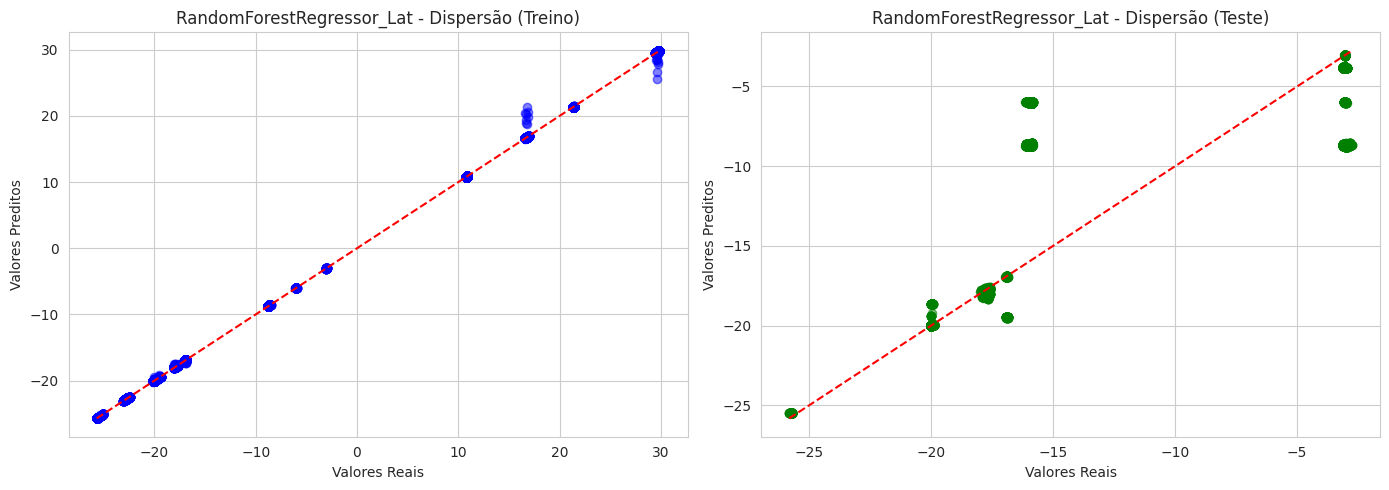


=== Avaliação do XGBRegressor_Lat ===
🔹 RMSE (Treino): 0.0306 | R² (Treino): 1.0000
🔹 RMSE (Teste): 3.4788 | R² (Teste): 0.8105


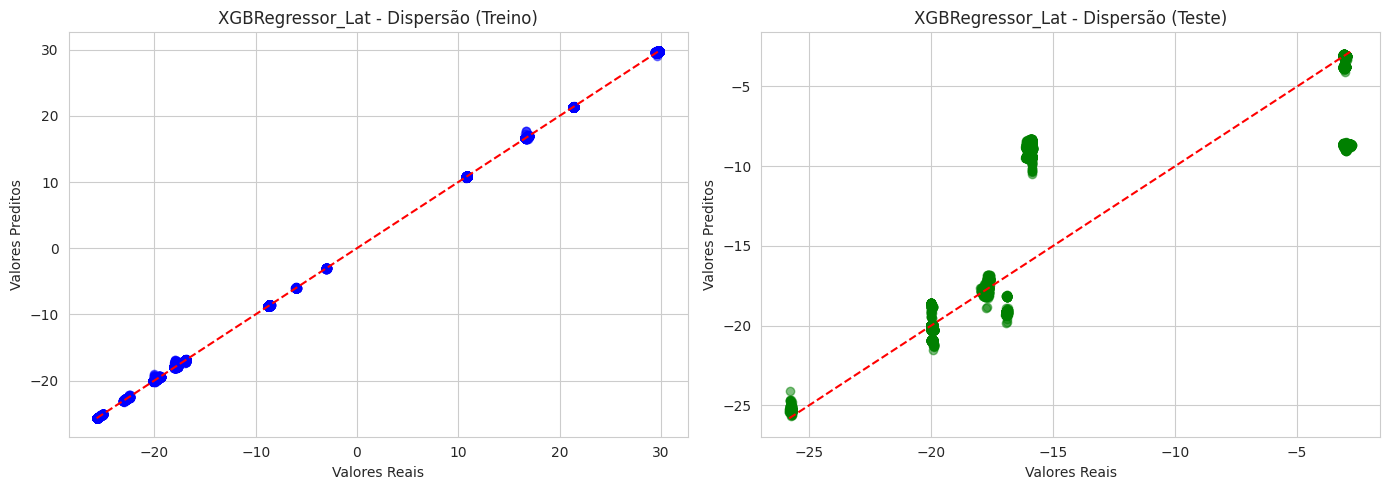


=== Avaliação do MetaModel_Lat (Ensemble) ===
🔹 RMSE (Treino): 0.0273 | R² (Treino): 1.0000
🔹 RMSE (Teste): 3.6189 | R² (Teste): 0.7950


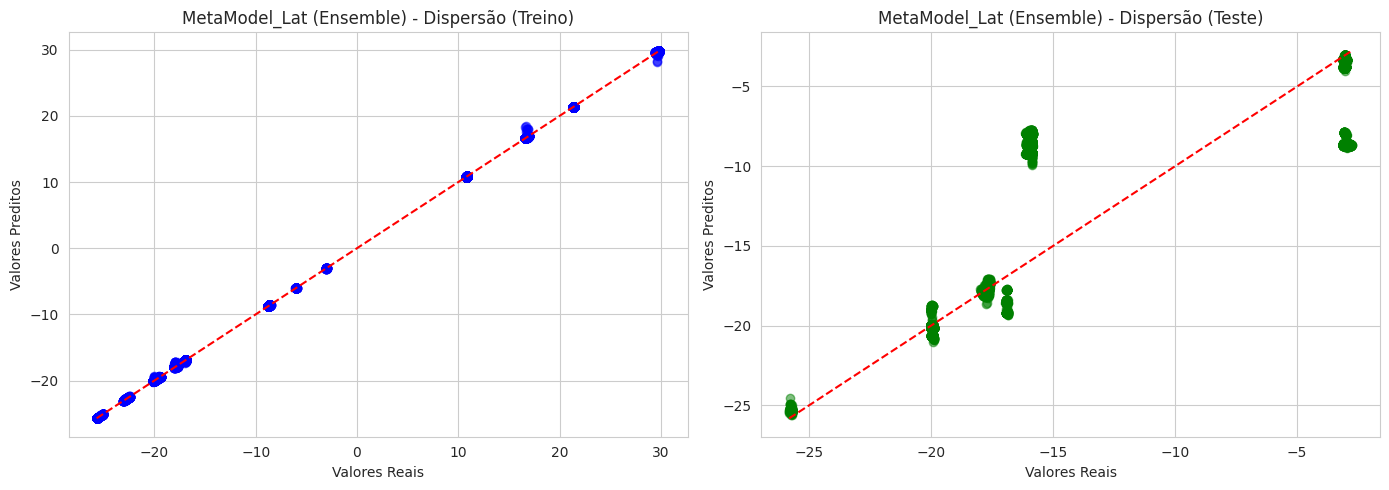


=== Avaliação do RandomForestRegressor_Long ===
🔹 RMSE (Treino): 0.0517 | R² (Treino): 1.0000
🔹 RMSE (Teste): 7.8700 | R² (Teste): -0.6607


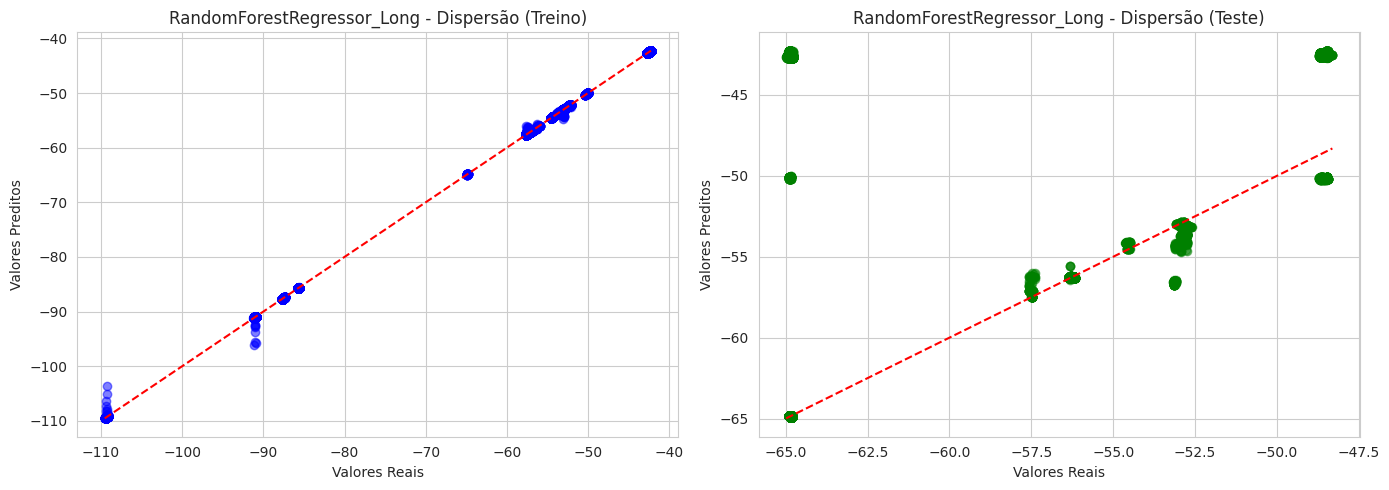


=== Avaliação do XGBRegressor_Long ===
🔹 RMSE (Treino): 0.0580 | R² (Treino): 1.0000
🔹 RMSE (Teste): 8.0908 | R² (Teste): -0.7552


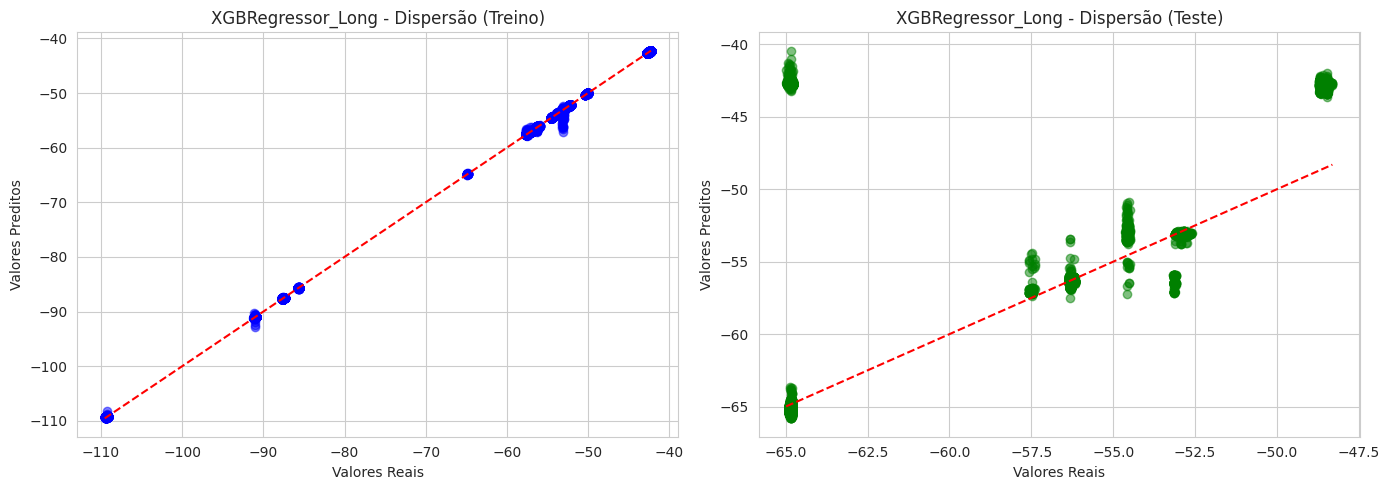


=== Avaliação do MetaModel_Long (Ensemble) ===
🔹 RMSE (Treino): 0.0437 | R² (Treino): 1.0000
🔹 RMSE (Teste): 7.8935 | R² (Teste): -0.6707


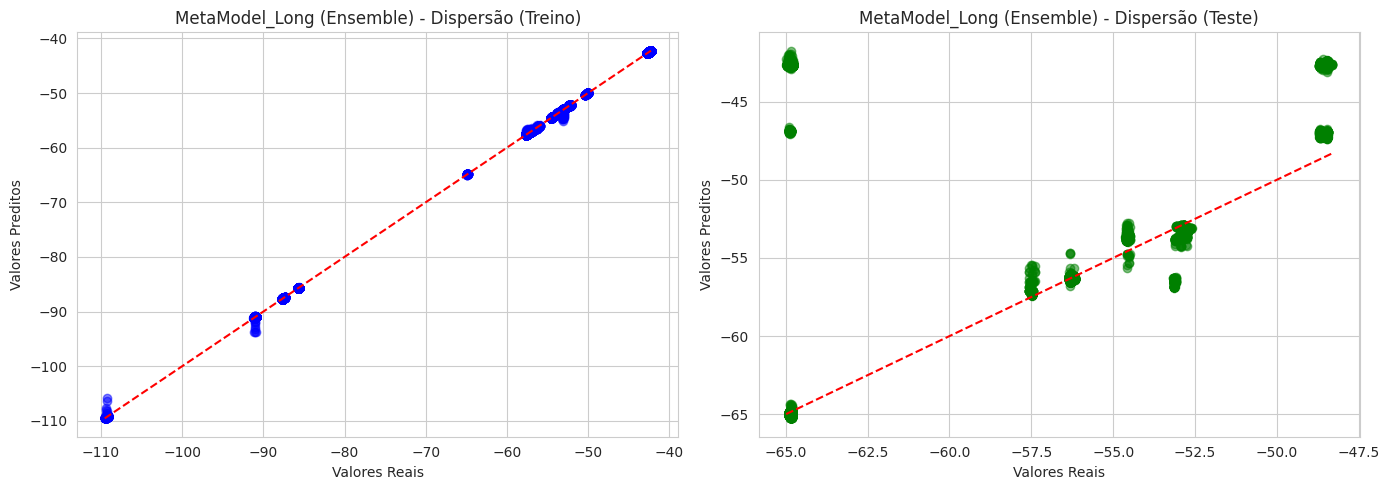


📊  Resultados da Regressão:
                    Modelo  RMSE (Treino)  R² (Treino)  RMSE (Teste)  R² (Teste)
 RandomForestRegressor_Lat       0.041087     0.999989      3.976833    0.752389
          XGBRegressor_Lat       0.030636     0.999994      3.478808    0.810523
  MetaModel_Lat (Ensemble)       0.027272     0.999995      3.618942    0.794950
RandomForestRegressor_Long       0.051729     0.999985      7.869959   -0.660692
         XGBRegressor_Long       0.057970     0.999982      8.090820   -0.755210
 MetaModel_Long (Ensemble)       0.043719     0.999990      7.893549   -0.670662


In [ ]:

#  Avaliação dos Modelos de Regressão (Latitude e Longitude)
print("\n📊 Avaliação dos Modelos de Regressão (Latitude e Longitude)")

regression_results = []

models_regression = {
    "RandomForestRegressor_Lat": trained_models["RandomForestRegressor_Lat"],
    "XGBRegressor_Lat": trained_models["XGBRegressor_Lat"],
    "MetaModel_Lat (Ensemble)": trained_models["MetaModel_Lat"],
    "RandomForestRegressor_Long": trained_models["RandomForestRegressor_Long"],
    "XGBRegressor_Long": trained_models["XGBRegressor_Long"],
    "MetaModel_Long (Ensemble)": trained_models["MetaModel_Long"]
}

# Avaliar cada modelo de Regressão
for model_name, model in models_regression.items():
    #  Para os MetaModels, usamos as features combinadas das previsões
    if "MetaModel" in model_name:
        X_train_used = X_meta_train_lat if "Lat" in model_name else X_meta_train_long
        X_test_used = X_meta_test_lat if "Lat" in model_name else X_meta_test_long
    else:
        X_train_used, X_test_used = X_train_loc, X_test_loc

    # Avaliar o modelo
    rmse_train, r2_train, rmse_test, r2_test = evaluate_models_reg(
        model_name, model,
        X_train_used, y_train_lat if "Lat" in model_name else y_train_long,
        X_test_used, y_test_lat if "Lat" in model_name else y_test_long
    )

    regression_results.append([model_name, rmse_train, r2_train, rmse_test, r2_test])

# Criar DataFrame organizado para Regressão
df_regression = pd.DataFrame(
    regression_results,
    columns=["Modelo", "RMSE (Treino)", "R² (Treino)", "RMSE (Teste)", "R² (Teste)"]
)

#  Exibir Resultados Formatados
print("\n📊  Resultados da Regressão:")
print(df_regression.to_string(index=False))
